<a href="https://colab.research.google.com/github/AbyssDrn/Animal-Sound-Classifier/blob/main/SiMoni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ANIMAL SPECIES AUDIO CLASSIFICATION PROJECT**

Low-Power Offline Device for Biodiversity Monitoring

Author: Amal Madhu

Date: October 23, 2025

The notebook demonstrates a complete pipeline for classifying animal species from audio calls using deep learning, optimized for edge deployment.

**1: ENVIRONMENT SETUP**

In [1]:
print("=" * 70)
print("ANIMAL SPECIES AUDIO CLASSIFICATION - BIODIVERSITY MONITORING")
print("=" * 70)
print("\nInstalling required packages...\n")

!pip install -q librosa soundfile scikit-learn matplotlib seaborn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("All packages installed successfully!\n")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}\n")

ANIMAL SPECIES AUDIO CLASSIFICATION - BIODIVERSITY MONITORING

Installing required packages...

All packages installed successfully!

TensorFlow version: 2.19.0
GPU Available: True



**2: MOUNTING GOOGLE DRIVE & SETUP DATA DIRECTORY**

In [2]:
print("=" * 70)
print("SECTION 2: MOUNTING GOOGLE DRIVE")
print("=" * 70)

from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = '/content/drive/MyDrive/AnimalSounds'

print(f"\nData directory: {DATA_PATH}")
print("Ensuring audio files are organized in species folders\n")

SECTION 2: MOUNTING GOOGLE DRIVE
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Data directory: /content/drive/MyDrive/AnimalSounds
Ensuring audio files are organized in species folders



**3: LOADING AUDIO DATASET FROM GOOGLE DRIVE**

In [3]:
print("=" * 70)
print("SECTION 3: LOADING AUDIO DATASET")
print("=" * 70)

# Audio parameters
SAMPLE_RATE = 22050
DURATION = 3
MAX_SAMPLES_PER_SPECIES = 100

# Supported audio formats
AUDIO_EXTENSIONS = ['.wav', '.mp3', '.ogg', '.flac', '.m4a']

def load_audio_file(file_path, sample_rate=22050, duration=3):
    """Load and preprocess audio file"""
    try:
        audio, sr = librosa.load(file_path, sr=sample_rate, duration=duration, mono=True)

        target_length = sample_rate * duration
        if len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
        else:
            audio = audio[:target_length]

        return audio
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def load_dataset_from_directory(data_path, max_samples_per_class=100):
    """Load audio dataset organized in folders by species"""
    audio_data = []
    labels = []
    file_paths = []

    data_path = Path(data_path)

    if not data_path.exists():
        print(f"ERROR: Directory {data_path} does not exist!")
        return None, None, None

    species_folders = [f for f in data_path.iterdir() if f.is_dir()]

    if len(species_folders) == 0:
        print(f"ERROR: No species folders found in {data_path}")
        return None, None, None

    print(f"\nFound {len(species_folders)} species folders")
    print("Loading audio files...\n")

    for species_folder in sorted(species_folders):
        species_name = species_folder.name
        audio_files = []

        for ext in AUDIO_EXTENSIONS:
            audio_files.extend(species_folder.glob(f'*{ext}'))

        audio_files = audio_files[:max_samples_per_class]

        print(f"Loading {species_name}: {len(audio_files)} files")

        loaded_count = 0
        for audio_file in audio_files:
            audio = load_audio_file(audio_file, SAMPLE_RATE, DURATION)
            if audio is not None:
                audio_data.append(audio)
                labels.append(species_name)
                file_paths.append(str(audio_file))
                loaded_count += 1

        print(f"  Successfully loaded: {loaded_count}/{len(audio_files)} files")

    return np.array(audio_data), np.array(labels), file_paths

# Load the dataset
audio_data, labels, file_paths = load_dataset_from_directory(DATA_PATH, MAX_SAMPLES_PER_SPECIES)

if audio_data is None or len(audio_data) == 0:
    print("\n" + "="*70)
    print("DATASET NOT FOUND - USING SYNTHETIC DATA")
    print("="*70)

    SPECIES = ['Dog', 'Cat', 'Bird', 'Frog', 'Cow', 'Elephant', 'Wolf', 'Dolphin']
    N_SAMPLES = 50

    def generate_synthetic_sound(species, sr=22050, dur=3):
        t = np.linspace(0, dur, int(sr * dur))
        freq_map = {'Dog': 500, 'Cat': 600, 'Bird': 2000, 'Frog': 300,
                    'Cow': 200, 'Elephant': 150, 'Wolf': 400, 'Dolphin': 8000}
        freq = freq_map.get(species, 500)
        signal = np.sin(2 * np.pi * freq * t) * np.exp(-t/dur)
        signal += np.random.normal(0, 0.05, len(t))
        return signal.astype(np.float32)

    audio_data = []
    labels = []
    for species in SPECIES:
        for i in range(N_SAMPLES):
            audio_data.append(generate_synthetic_sound(species, SAMPLE_RATE, DURATION))
            labels.append(species)

    audio_data = np.array(audio_data)
    labels = np.array(labels)
    print(f"Generated synthetic dataset: {len(audio_data)} samples\n")
else:
    print(f"\nDataset loaded successfully!")
    print(f"Total samples: {len(audio_data)}")
    print(f"Audio shape per sample: {audio_data[0].shape}")
    print(f"Duration: {DURATION}s | Sample rate: {SAMPLE_RATE}Hz\n")

# Get unique species
SPECIES = sorted(list(set(labels)))
print(f"Species in dataset: {SPECIES}")
print(f"Number of species: {len(SPECIES)}\n")

# Check for class imbalance
print("Class distribution:")
for species in SPECIES:
    count = np.sum(labels == species)
    print(f"  {species}: {count} samples")
print()

SECTION 3: LOADING AUDIO DATASET

Found 10 species folders
Loading audio files...

Loading Bird: 100 files
  Successfully loaded: 100/100 files
Loading Cat: 99 files
  Successfully loaded: 99/99 files
Loading Chicken: 30 files
  Successfully loaded: 30/30 files
Loading Cow: 75 files
  Successfully loaded: 75/75 files
Loading Dog: 100 files
  Successfully loaded: 100/100 files
Loading Donkey: 25 files
  Successfully loaded: 25/25 files
Loading Frog: 35 files
  Successfully loaded: 35/35 files
Loading Lion: 45 files
  Successfully loaded: 45/45 files
Loading Monkey: 25 files
  Successfully loaded: 25/25 files
Loading Sheep: 40 files
  Successfully loaded: 40/40 files

Dataset loaded successfully!
Total samples: 574
Audio shape per sample: (66150,)
Duration: 3s | Sample rate: 22050Hz

Species in dataset: [np.str_('Bird'), np.str_('Cat'), np.str_('Chicken'), np.str_('Cow'), np.str_('Dog'), np.str_('Donkey'), np.str_('Frog'), np.str_('Lion'), np.str_('Monkey'), np.str_('Sheep')]
Number of s

**4: EXPLORATORY DATA ANALYSIS**

SECTION 4: EXPLORATORY DATA ANALYSIS


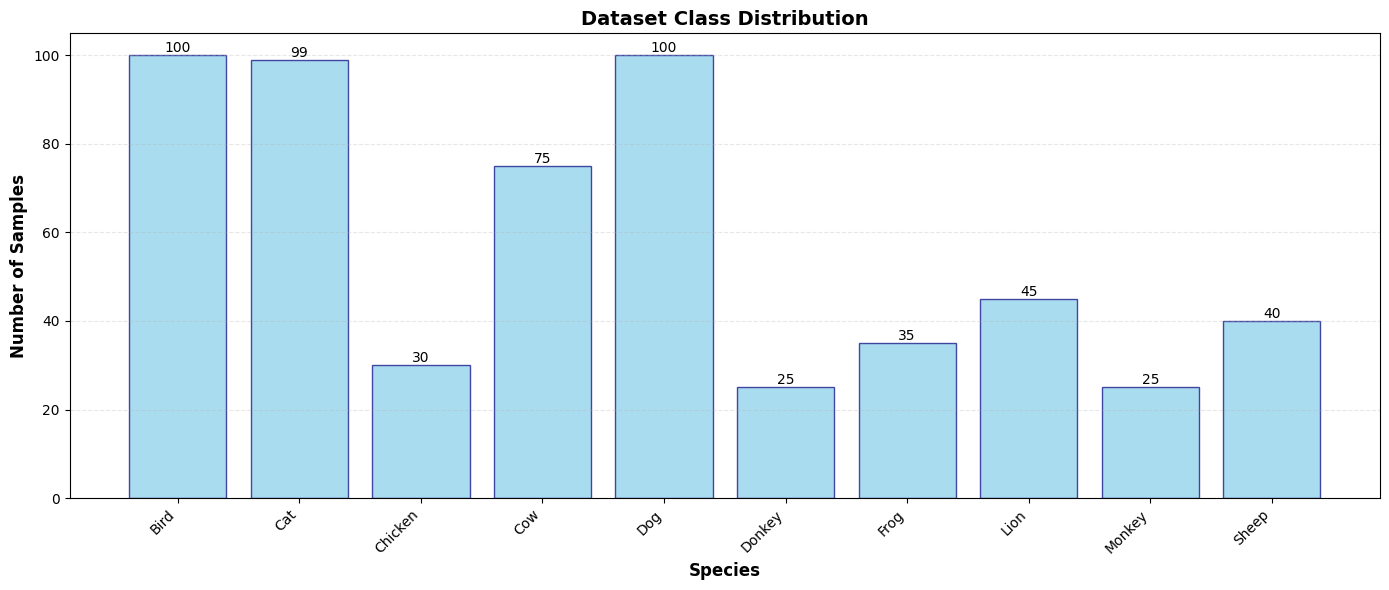

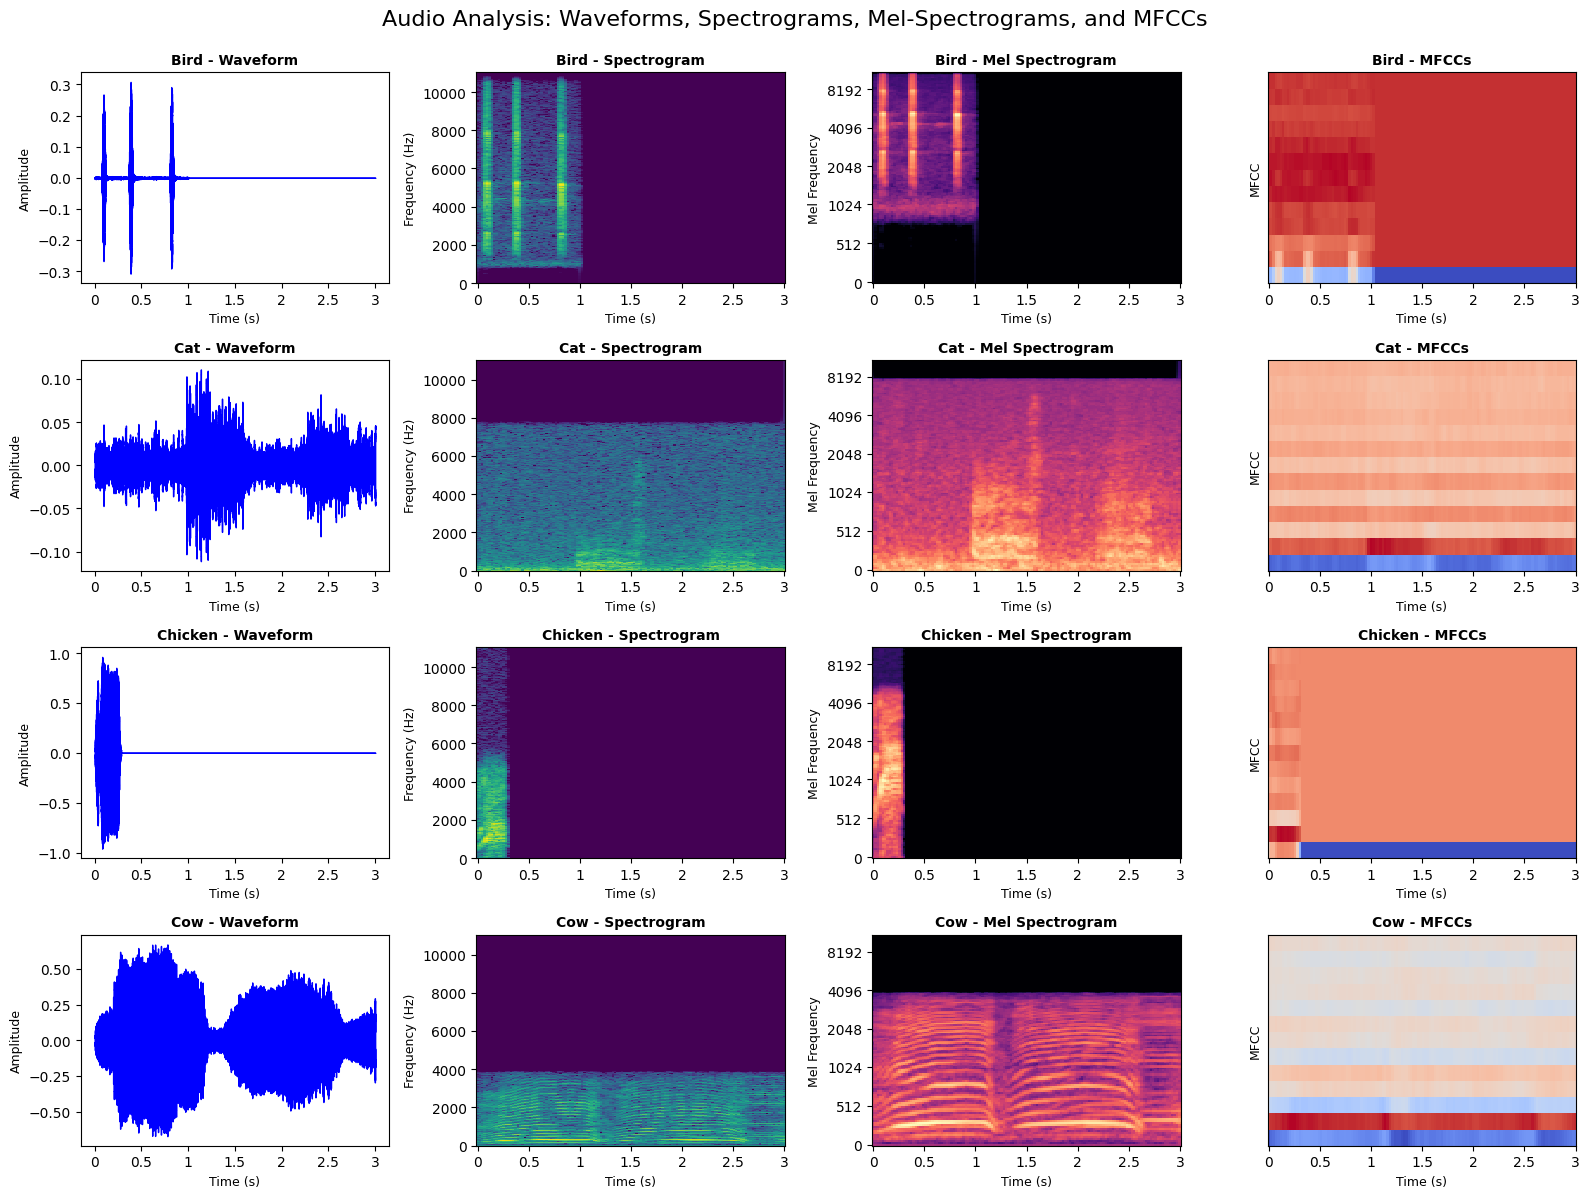

In [4]:
print("=" * 70)
print("SECTION 4: EXPLORATORY DATA ANALYSIS")
print("=" * 70)

# Class distribution
plt.figure(figsize=(14, 6))
unique, counts = np.unique(labels, return_counts=True)
bars = plt.bar(range(len(unique)), counts, color='skyblue', edgecolor='navy', alpha=0.7)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.xlabel('Species', fontsize=12, fontweight='bold')
plt.ylabel('Number of Samples', fontsize=12, fontweight='bold')
plt.title('Dataset Class Distribution', fontsize=14, fontweight='bold')
plt.xticks(range(len(unique)), unique, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Visualize sample waveforms and spectrograms
num_species_to_show = min(4, len(SPECIES))  # Show max 4 species for clarity
fig, axes = plt.subplots(num_species_to_show, 4, figsize=(16, 3*num_species_to_show))
fig.suptitle('Audio Analysis: Waveforms, Spectrograms, Mel-Spectrograms, and MFCCs',
             fontsize=16, y=0.995)

# Handle single species case
if num_species_to_show == 1:
    axes = axes.reshape(1, -1)

for idx, species in enumerate(SPECIES[:num_species_to_show]):
    species_idx = np.where(labels == species)[0][0]
    audio_sample = audio_data[species_idx]

    # Waveform
    ax1 = axes[idx, 0]
    librosa.display.waveshow(audio_sample, sr=SAMPLE_RATE, ax=ax1, color='blue')
    ax1.set_title(f'{species} - Waveform', fontweight='bold', fontsize=10)
    ax1.set_xlabel('Time (s)', fontsize=9)
    ax1.set_ylabel('Amplitude', fontsize=9)

    # Spectrogram
    ax2 = axes[idx, 1]
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_sample)), ref=np.max)
    librosa.display.specshow(D, sr=SAMPLE_RATE, x_axis='time', y_axis='hz', ax=ax2, cmap='viridis')
    ax2.set_title(f'{species} - Spectrogram', fontweight='bold', fontsize=10)
    ax2.set_xlabel('Time (s)', fontsize=9)
    ax2.set_ylabel('Frequency (Hz)', fontsize=9)

    # Mel Spectrogram
    ax3 = axes[idx, 2]
    mel_spec = librosa.feature.melspectrogram(y=audio_sample, sr=SAMPLE_RATE, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    librosa.display.specshow(mel_spec_db, sr=SAMPLE_RATE, x_axis='time', y_axis='mel', ax=ax3, cmap='magma')
    ax3.set_title(f'{species} - Mel Spectrogram', fontweight='bold', fontsize=10)
    ax3.set_xlabel('Time (s)', fontsize=9)
    ax3.set_ylabel('Mel Frequency', fontsize=9)

    # MFCCs
    ax4 = axes[idx, 3]
    mfccs = librosa.feature.mfcc(y=audio_sample, sr=SAMPLE_RATE, n_mfcc=13)
    librosa.display.specshow(mfccs, sr=SAMPLE_RATE, x_axis='time', ax=ax4, cmap='coolwarm')
    ax4.set_title(f'{species} - MFCCs', fontweight='bold', fontsize=10)
    ax4.set_xlabel('Time (s)', fontsize=9)
    ax4.set_ylabel('MFCC', fontsize=9)

plt.tight_layout()
plt.show()

**5: INITIATING FEATURE EXTRACTION**

In [5]:
print("\n" + "=" * 70)
print("SECTION 5: FEATURE EXTRACTION WITH DATA AUGMENTATION")
print("=" * 70)
print("\nExtracting Mel-spectrograms with augmentation for better generalization...\n")

def add_noise(audio, noise_factor=0.005):
    """Add random noise to audio"""
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    return augmented_audio

def time_shift(audio, shift_max=0.2):
    """Shift audio in time"""
    shift = np.random.randint(int(len(audio) * shift_max))
    direction = np.random.choice(['left', 'right'])
    if direction == 'right':
        return np.pad(audio[:-shift], (shift, 0), mode='constant')
    else:
        return np.pad(audio[shift:], (0, shift), mode='constant')

def extract_mel_spectrogram(audio, sample_rate=22050, n_mels=128, n_fft=2048, hop_length=512, target_length=130):
    """Extract Mel-spectrogram features from audio with FIXED time dimension"""
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=sample_rate,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length
    )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # CRITICAL FIX: Ensure all spectrograms have same shape
    if mel_spec_db.shape[1] < target_length:
        # Pad if too short
        pad_width = target_length - mel_spec_db.shape[1]
        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant', constant_values=-80)
    elif mel_spec_db.shape[1] > target_length:
        # Trim if too long
        mel_spec_db = mel_spec_db[:, :target_length]

    return mel_spec_db

# First, determine the target spectrogram length from sample data
print("Determining spectrogram dimensions...")
sample_specs = []
for i in range(min(10, len(audio_data))):
    spec = librosa.feature.melspectrogram(y=audio_data[i], sr=SAMPLE_RATE, n_mels=128)
    sample_specs.append(spec.shape[1])

target_time_length = int(np.median(sample_specs))
print(f"Target spectrogram time dimension: {target_time_length}\n")

# Extract features with augmentation
print("Processing audio samples with augmentation...")
features = []
augmented_labels = []

for i, (audio, label) in enumerate(zip(audio_data, labels)):
    # Original audio
    mel_spec = extract_mel_spectrogram(audio, SAMPLE_RATE, target_length=target_time_length)
    features.append(mel_spec)
    augmented_labels.append(label)

    # Augmentation 1: Add noise
    noisy_audio = add_noise(audio)
    mel_spec_noisy = extract_mel_spectrogram(noisy_audio, SAMPLE_RATE, target_length=target_time_length)
    features.append(mel_spec_noisy)
    augmented_labels.append(label)

    # Augmentation 2: Time shift
    shifted_audio = time_shift(audio)
    mel_spec_shifted = extract_mel_spectrogram(shifted_audio, SAMPLE_RATE, target_length=target_time_length)
    features.append(mel_spec_shifted)
    augmented_labels.append(label)

    if (i + 1) % 50 == 0:
        print(f"  Processed {i + 1}/{len(audio_data)} samples (with augmentation)")

features = np.array(features)
augmented_labels = np.array(augmented_labels)

print(f"\nFeature extraction complete!")
print(f"   Original samples: {len(audio_data)}")
print(f"   Augmented samples: {len(features)}")
print(f"   Feature shape: {features.shape}")
print(f"   (samples, mel_bins, time_frames)\n")

# Normalize features
features_mean = features.mean()
features_std = features.std()
features = (features - features_mean) / features_std

# Reshape for CNN input (add channel dimension)
features = features[..., np.newaxis]
print(f"   Reshaped for CNN: {features.shape}\n")


SECTION 5: FEATURE EXTRACTION WITH DATA AUGMENTATION

Extracting Mel-spectrograms with augmentation for better generalization...

Determining spectrogram dimensions...
Target spectrogram time dimension: 130

Processing audio samples with augmentation...
  Processed 50/574 samples (with augmentation)
  Processed 100/574 samples (with augmentation)
  Processed 150/574 samples (with augmentation)
  Processed 200/574 samples (with augmentation)
  Processed 250/574 samples (with augmentation)
  Processed 300/574 samples (with augmentation)
  Processed 350/574 samples (with augmentation)
  Processed 400/574 samples (with augmentation)
  Processed 450/574 samples (with augmentation)
  Processed 500/574 samples (with augmentation)
  Processed 550/574 samples (with augmentation)

Feature extraction complete!
   Original samples: 574
   Augmented samples: 1722
   Feature shape: (1722, 128, 130)
   (samples, mel_bins, time_frames)

   Reshaped for CNN: (1722, 128, 130, 1)



**6: INITIATING DATA PREPARATION**

In [6]:
print("=" * 70)
print("SECTION 6: DATA SPLITTING & ENCODING")
print("=" * 70)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(augmented_labels)
labels_categorical = keras.utils.to_categorical(labels_encoded)

print(f"Label encoding:")
for i, species in enumerate(label_encoder.classes_):
    print(f"  {i}: {species}")
print()

# Split data: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    features, labels_categorical, test_size=0.3, random_state=42, stratify=labels_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp.argmax(axis=1)
)

print(f"Data Split:")
print(f"   Training:   {X_train.shape[0]} samples ({X_train.shape[0]/len(features)*100:.1f}%)")
print(f"   Validation: {X_val.shape[0]} samples ({X_val.shape[0]/len(features)*100:.1f}%)")
print(f"   Testing:    {X_test.shape[0]} samples ({X_test.shape[0]/len(features)*100:.1f}%)")
print(f"\n   Input shape: {X_train.shape[1:]}")
print(f"   Number of classes: {len(SPECIES)}\n")

SECTION 6: DATA SPLITTING & ENCODING
Label encoding:
  0: Bird
  1: Cat
  2: Chicken
  3: Cow
  4: Dog
  5: Donkey
  6: Frog
  7: Lion
  8: Monkey
  9: Sheep

Data Split:
   Training:   1205 samples (70.0%)
   Validation: 258 samples (15.0%)
   Testing:    259 samples (15.0%)

   Input shape: (128, 130, 1)
   Number of classes: 10



**7: MODEL ARCHITECTURE (LIGHTWEIGHT CNN)**

In [7]:
print("=" * 70)
print("SECTION 7: BUILDING IMPROVED LIGHTWEIGHT CNN MODEL")
print("=" * 70)
print("\nCreating optimized model for edge deployment...\n")

def create_improved_cnn(input_shape, num_classes):
    """Improved lightweight CNN with better feature extraction"""
    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                     input_shape=input_shape, name='conv1'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1b'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2b'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Global Average Pooling instead of Flatten
        layers.GlobalAveragePooling2D(),

        # Dense layers
        layers.Dense(256, activation='relu', name='dense1'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu', name='dense2'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax', name='output')
    ])

    return model

# Create model
model = create_improved_cnn(X_train.shape[1:], len(SPECIES))

# Compile with class weights if imbalanced
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights (to handle any imbalance):")
for i, species in enumerate(label_encoder.classes_):
    print(f"  {species}: {class_weight_dict[i]:.2f}")
print()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()

# Calculate model size
param_count = model.count_params()
model_size_mb = param_count * 4 / (1024 ** 2)
print(f"\nModel Statistics:")
print(f"   Total parameters: {param_count:,}")
print(f"   Estimated size: {model_size_mb:.2f} MB (float32)")
print(f"   Estimated size after quantization: ~{model_size_mb/4:.2f} MB (int8)\n")

SECTION 7: BUILDING IMPROVED LIGHTWEIGHT CNN MODEL

Creating optimized model for edge deployment...

Class weights (to handle any imbalance):
  Bird: 0.57
  Cat: 0.58
  Chicken: 1.91
  Cow: 0.77
  Dog: 0.57
  Donkey: 2.30
  Frog: 1.64
  Lion: 1.28
  Monkey: 2.30
  Sheep: 1.44



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 128, 130, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 130, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1b (Conv2D)                 │ (None, 128, 130, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 130, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 64, 65, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 65, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2b (Conv2D)                 │ (None, 64, 65, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 65, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 208,362 (813.91 KB)

 Trainable params: 207,210 (809.41 KB)

 Non-trainable params: 1,152 (4.50 KB)


Model Statistics:
   Total parameters: 208,362
   Estimated size: 0.79 MB (float32)
   Estimated size after quantization: ~0.20 MB (int8)



**8: INITIALIZING MODEL TRAINING**

In [8]:
print("=" * 70)
print("SECTION 8: TRAINING THE MODEL")
print("=" * 70)
print("\nTraining with callbacks and class weights...\n")

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining complete!\n")

SECTION 8: TRAINING THE MODEL

Training with callbacks and class weights...

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.1055 - loss: 3.1415
Epoch 1: val_accuracy improved from -inf to 0.17442, saving model to best_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 410ms/step - accuracy: 0.1068 - loss: 3.1368 - val_accuracy: 0.1744 - val_loss: 2.3021 - learning_rate: 0.0010
Epoch 2/100
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2324 - loss: 2.5180
Epoch 2: val_accuracy did not improve from 0.17442
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.2341 - loss: 2.5161 - val_accuracy: 0.1744 - val_loss: 2.3615 - learning_rate: 0.0010
Epoch 3/100
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3075 - loss: 2.1278
Epoch 3: val_accuracy did not improve from 0.17442
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.3081 - loss: 2.1306 - val_accuracy: 0.1589 - val_loss: 2.5695 - learning_rate: 0.0010
Epoch 4/100
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - 

**9: INITIATED TRAINING VISUALIZATION**

SECTION 9: TRAINING PERFORMANCE ANALYSIS


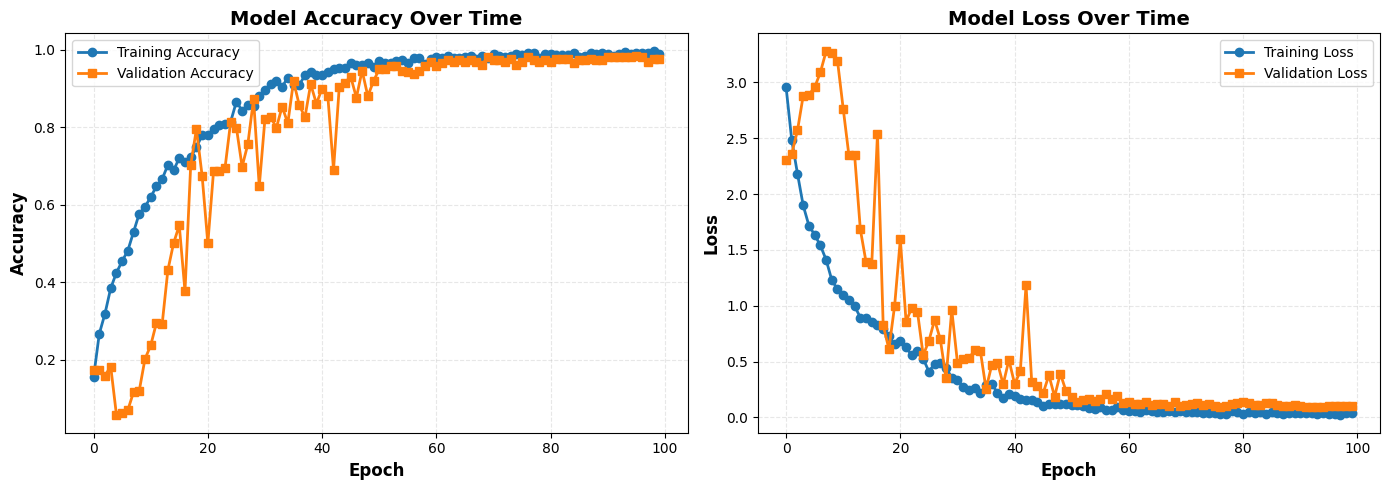


Final Training Accuracy: 98.92%
Final Validation Accuracy: 97.67%



In [9]:
print("=" * 70)
print("SECTION 9: TRAINING PERFORMANCE ANALYSIS")
print("=" * 70)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s')
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, linestyle='--')

# Loss
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2, marker='o')
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='s')
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[1].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy: {final_train_acc*100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc*100:.2f}%\n")

**10: INITIATED MODEL EVALUATION**

SECTION 9: TRAINING PERFORMANCE ANALYSIS


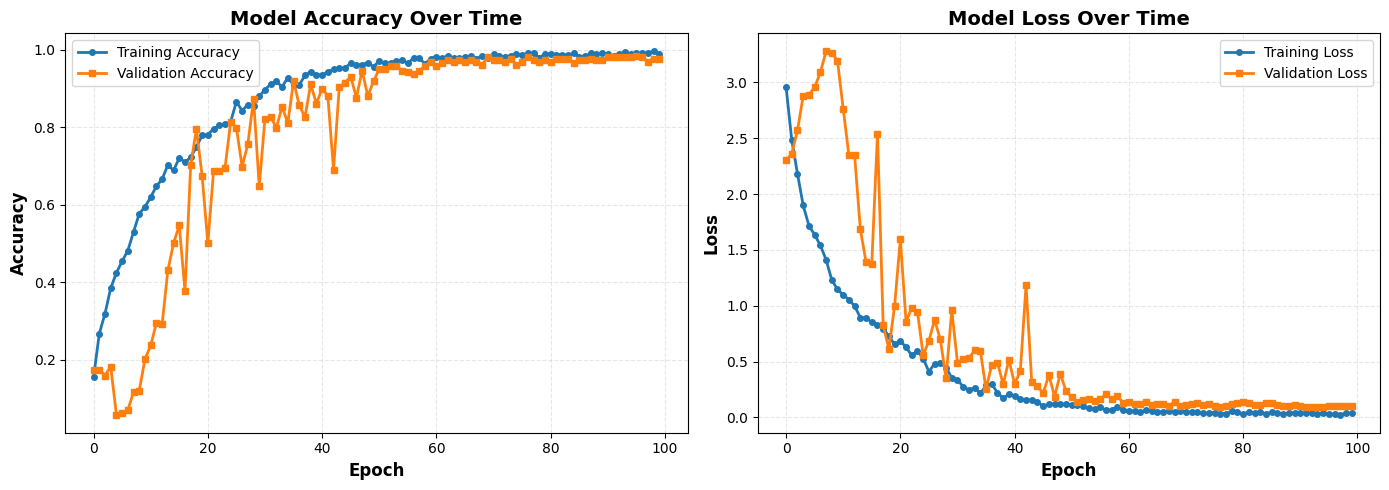


Final Training Accuracy: 98.92%
Final Validation Accuracy: 97.67%

SECTION 10: MODEL EVALUATION ON TEST SET

Test Set Performance:
   Loss: 0.0490
   Accuracy: 0.9923 (99.23%)

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Bird      1.000     1.000     1.000        45
         Cat      0.978     0.978     0.978        45
     Chicken      0.929     1.000     0.963        13
         Cow      1.000     0.971     0.985        34
         Dog      1.000     1.000     1.000        45
      Donkey      1.000     1.000     1.000        11
        Frog      1.000     1.000     1.000        16
        Lion      1.000     1.000     1.000        21
      Monkey      1.000     1.000     1.000        11
       Sheep      1.000     1.000     1.000        18

    accuracy                          0.992       259
   macro avg      0.991     0.995     0.993       259
weighted avg      0.993     0.992     0.992       259



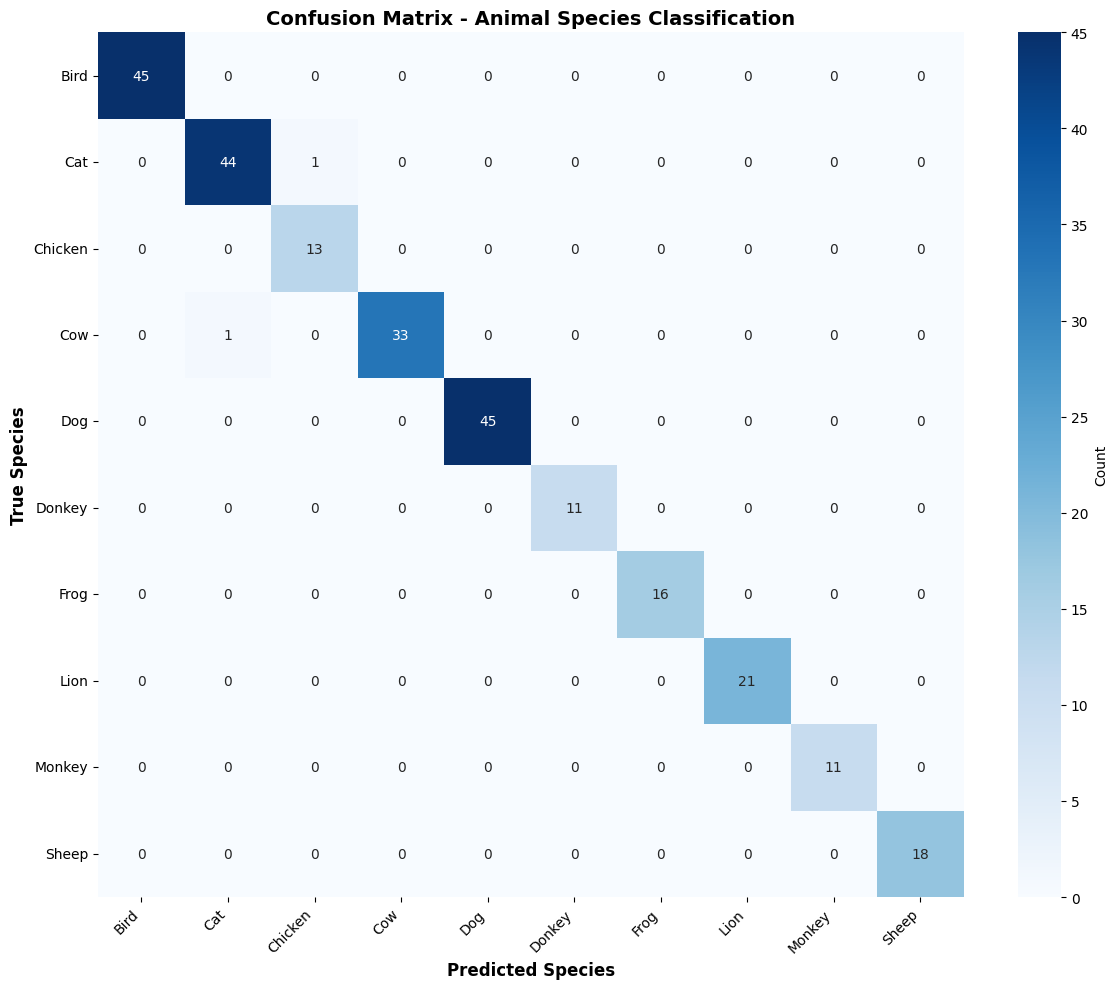


Per-Class Accuracy:
----------------------------------------
   Bird           : 100.00% (45 samples)
   Cat            :  97.78% (45 samples)
   Chicken        : 100.00% (13 samples)
   Cow            :  97.06% (34 samples)
   Dog            : 100.00% (45 samples)
   Donkey         : 100.00% (11 samples)
   Frog           : 100.00% (16 samples)
   Lion           : 100.00% (21 samples)
   Monkey         : 100.00% (11 samples)
   Sheep          : 100.00% (18 samples)



In [10]:
print("=" * 70)
print("SECTION 9: TRAINING PERFORMANCE ANALYSIS")
print("=" * 70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o', markersize=4)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, linestyle='--')

# Loss
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2, marker='o', markersize=4)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='s', markersize=4)
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[1].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy: {final_train_acc*100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc*100:.2f}%\n")

# ============================================================================
# SECTION 10: COMPREHENSIVE MODEL EVALUATION
# ============================================================================

print("=" * 70)
print("SECTION 10: MODEL EVALUATION ON TEST SET")
print("=" * 70)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Set Performance:")
print(f"   Loss: {test_loss:.4f}")
print(f"   Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)\n")

# Predictions
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print("=" * 70)
print("DETAILED CLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=label_encoder.classes_,
    digits=3
))

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Species', fontsize=12, fontweight='bold')
plt.ylabel('True Species', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Animal Species Classification', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\nPer-Class Accuracy:")
print("-" * 40)
for i, species in enumerate(label_encoder.classes_):
    class_mask = y_true_classes == i
    if class_mask.sum() > 0:
        class_acc = (y_pred_classes[class_mask] == i).sum() / class_mask.sum()
        class_samples = class_mask.sum()
        print(f"   {species:15s}: {class_acc*100:6.2f}% ({class_samples} samples)")
print()

**11: MODEL OPTIMIZATION FOR EDGE DEPLOYMENT**

In [11]:
print("\n" + "=" * 70)
print("SECTION 11: MODEL OPTIMIZATION FOR LOW-POWER DEPLOYMENT")
print("=" * 70)
print("\nConverting model to TensorFlow Lite with quantization...\n")

# Convert to TensorFlow Lite with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Apply quantization for smaller model size and faster inference
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert
tflite_model = converter.convert()

# Save the model
tflite_model_path = 'animal_classifier_quantized.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Calculate sizes
original_size = model_size_mb
tflite_size = len(tflite_model) / (1024 ** 2)

print(f"Model conversion complete!")
print(f"\nModel Size Comparison:")
print(f"   Original model (float32): {original_size:.2f} MB")
print(f"   TFLite quantized model:   {tflite_size:.2f} MB")
print(f"   Size reduction:           {(1 - tflite_size/original_size)*100:.1f}%\n")

# Test TFLite model inference
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test inference time
import time

sample_input = X_test[0:1].astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], sample_input)

# Warm-up run
interpreter.invoke()

# Measure inference time
start_time = time.time()
interpreter.invoke()
inference_time = (time.time() - start_time) * 1000  # Convert to ms

output_data = interpreter.get_tensor(output_details[0]['index'])

print(f"Inference Performance:")
print(f"   Inference time: {inference_time:.2f} ms")
print(f"   Suitable for: {'Real-time edge deployment' if inference_time < 500 else 'May need optimization'}\n")

# Verify TFLite model accuracy
print("Verifying TFLite model accuracy on test set...")
tflite_predictions = []
for i in range(len(X_test)):
    sample = X_test[i:i+1].astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], sample)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    tflite_predictions.append(np.argmax(output))

tflite_predictions = np.array(tflite_predictions)
tflite_accuracy = (tflite_predictions == y_true_classes).sum() / len(y_true_classes)
print(f"TFLite model accuracy: {tflite_accuracy*100:.2f}%")
print(f"Accuracy difference: {abs(test_accuracy - tflite_accuracy)*100:.2f}%\n")


SECTION 11: MODEL OPTIMIZATION FOR LOW-POWER DEPLOYMENT

Converting model to TensorFlow Lite with quantization...

Saved artifact at '/tmp/tmpvdkpr6d2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 130, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  131964546370640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131964546382352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131964546375056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131964546378128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131964546377744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131964546381584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131964546382928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131964546374096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131964546376016: TensorSpec(shape=(),

**12: REAL-TIME INFERENCE SIMULATION**

In [12]:
print("=" * 70)
print("SECTION 12: REAL-TIME INFERENCE SIMULATION")
print("=" * 70)
print("\nSimulating real-time animal detection on field recordings...\n")

# --- MODIFICATION: Prepare lists to store results ---
# We make these global so Cell 13 can access them
global sim_correct_indices, sim_incorrect_indices
sim_correct_indices = []
sim_incorrect_indices = []
# ---------------------------------------------------

# Simulate inference on random test samples
num_samples_to_test = min(8, len(X_test))
random_indices = np.random.choice(len(X_test), num_samples_to_test, replace=False)

print("Detection Results:")
print("-" * 70)

correct_predictions = 0
for idx in random_indices:
    sample = X_test[idx:idx+1].astype(np.float32)
    true_label = label_encoder.classes_[y_true_classes[idx]]

    # Inference
    interpreter.set_tensor(input_details[0]['index'], sample)
    interpreter.invoke()
    prediction = interpreter.get_tensor(output_details[0]['index'])[0]

    predicted_class = np.argmax(prediction)
    predicted_label = label_encoder.classes_[predicted_class]
    confidence = prediction[predicted_class] * 100

    is_correct = predicted_label == true_label
    status = "CORRECT" if is_correct else "INCORRECT"

    # --- MODIFICATION: Save the index to our new lists ---
    if is_correct:
        correct_predictions += 1
        sim_correct_indices.append(idx)
    else:
        sim_incorrect_indices.append(idx)
    # ----------------------------------------------------

    print(f"\nSample {idx}:")
    print(f"  True Species:        {true_label}")
    print(f"  Predicted Species: {predicted_label}")
    print(f"  Confidence:          {confidence:.1f}%")
    print(f"  Status:              {status}")

    # Show top 3 predictions
    top3_idx = np.argsort(prediction)[-3:][::-1]
    print(f"  Top 3 predictions:")
    for i, class_idx in enumerate(top3_idx):
        print(f"    {i+1}. {label_encoder.classes_[class_idx]}: {prediction[class_idx]*100:.1f}%")

print(f"\n{'-'*70}")
print(f"Simulation Accuracy: {correct_predictions}/{num_samples_to_test} ({correct_predictions/num_samples_to_test*100:.1f}%)")

# --- MODIFICATION: Confirm results are saved ---
print(f"\nSaved {len(sim_correct_indices)} correct and {len(sim_incorrect_indices)} incorrect indices for Cell 13.")
print("=" * 70)

SECTION 12: REAL-TIME INFERENCE SIMULATION

Simulating real-time animal detection on field recordings...

Detection Results:
----------------------------------------------------------------------

Sample 204:
  True Species:        Frog
  Predicted Species: Frog
  Confidence:          100.0%
  Status:              CORRECT
  Top 3 predictions:
    1. Frog: 100.0%
    2. Chicken: 0.0%
    3. Lion: 0.0%

Sample 243:
  True Species:        Dog
  Predicted Species: Dog
  Confidence:          100.0%
  Status:              CORRECT
  Top 3 predictions:
    1. Dog: 100.0%
    2. Monkey: 0.0%
    3. Cat: 0.0%

Sample 145:
  True Species:        Chicken
  Predicted Species: Chicken
  Confidence:          100.0%
  Status:              CORRECT
  Top 3 predictions:
    1. Chicken: 100.0%
    2. Bird: 0.0%
    3. Frog: 0.0%

Sample 172:
  True Species:        Dog
  Predicted Species: Dog
  Confidence:          99.9%
  Status:              CORRECT
  Top 3 predictions:
    1. Dog: 99.9%
    2. Monkey: 

**12.5: DOWNLOAD AND SAVE SPECIES IMAGES FOR DEPLOYMENT**

In [26]:
import requests
from PIL import Image
from io import BytesIO
import os
import json
import time
import datetime
import matplotlib.pyplot as plt
import random

# Create directory for species images and data
SPECIES_DIR = 'species_data'
IMAGES_DIR = os.path.join(SPECIES_DIR, 'images')
os.makedirs(IMAGES_DIR, exist_ok=True)

# Updated URLs - using sources less likely to rate-limit
SPECIES_IMAGE_URLS = {
    'Lion': 'https://www.public-domain-image.com/public-domain-images-pictures-free-stock-photos/fauna-animals-public-domain-images-pictures/lion-public-domain-images-pictures/male-lion-african-lion.jpg',
    'Cat': 'https://images.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg?auto=compress&cs=tinysrgb&w=640',
    'Bird': 'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?auto=compress&cs=tinysrgb&w=640',
    'Dog': 'https://images.pexels.com/photos/58997/pexels-photo-58997.jpeg?auto=compress&cs=tinysrgb&w=640',
    'Cow': 'https://images.pexels.com/photos/422218/pexels-photo-422218.jpeg?auto=compress&cs=tinysrgb&w=640',
    'Monkey': 'https://images.pexels.com/photos/1670413/pexels-photo-1670413.jpeg?auto=compress&cs=tinysrgb&w=640',
    'Chicken': 'https://images.unsplash.com/photo-1548550023-2bdb3c5beed7?w=640',
    'Donkey': 'https://images.pexels.com/photos/4680345/pexels-photo-4680345.jpeg?auto=compress&cs=tinysrgb&w=600',
    'Frog': 'https://images.pexels.com/photos/70083/frog-macro-amphibian-green-70083.jpeg?auto=compress&cs=tinysrgb&w=640',
    'Sheep': 'https://images.pexels.com/photos/288621/pexels-photo-288621.jpeg?auto=compress&cs=tinysrgb&w=640'
}

# Browser-like headers
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
    'Accept': 'image/avif,image/webp,image/apng,image/svg+xml,image/jpeg,image/png,*/*;q=0.8',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.9',
    'Connection': 'keep-alive',
    'Referer': 'https://www.google.com/'
}

def download_image(url, save_path, max_retries=3):
    """Download image from URL with proper rate-limit handling"""
    for attempt in range(max_retries):
        try:
            print(f"  Downloading (attempt {attempt + 1}/{max_retries})...", end=' ')

            # Create a new session for each request
            session = requests.Session()
            response = session.get(url, headers=HEADERS, timeout=30, allow_redirects=True)

            if response.status_code == 200:
                img = Image.open(BytesIO(response.content))
                img = img.convert('RGB')
                img.thumbnail((800, 800), Image.Resampling.LANCZOS)
                img.save(save_path, 'JPEG', quality=85, optimize=True)
                print("SUCCESS")
                return True
            elif response.status_code == 429:
                # Rate limited - wait longer before retry
                wait_time = 5 + (attempt * 5) + random.uniform(1, 3)
                print(f"RATE LIMITED - waiting {wait_time:.1f}s")
                time.sleep(wait_time)
            else:
                print(f"HTTP {response.status_code}")

        except Exception as e:
            print(f"FAILED ({str(e)[:50]})")

        if attempt < max_retries - 1:
            # Add randomized delay between retries
            delay = 3 + random.uniform(1, 3)
            time.sleep(delay)

    return False

# Download images
print("Downloading species images...")
print("(Using Pexels CDN for reliable downloads)\n")

download_success = {}

for i, (species, url) in enumerate(SPECIES_IMAGE_URLS.items()):
    print(f"{species}:")
    image_path = os.path.join(IMAGES_DIR, f'{species.lower()}.jpg')
    success = download_image(url, image_path)
    download_success[species] = success

    if success:
        file_size = os.path.getsize(image_path) / 1024
        print(f"  Saved: {image_path} ({file_size:.1f} KB)\n")
    else:
        print(f"  WARNING: Failed to download {species} image\n")

    # KEY FIX: Add longer delay between downloads (3-5 seconds)
    if i < len(SPECIES_IMAGE_URLS) - 1:
        delay = 3 + random.uniform(0, 2)
        print(f"  (Waiting {delay:.1f}s before next download...)")
        time.sleep(delay)

# Summary
print("\n" + "=" * 70)
print("DOWNLOAD SUMMARY")
print("=" * 70)

successful = sum(download_success.values())
total = len(download_success)

print(f"\nImages downloaded: {successful}/{total}")
print(f"Success rate: {successful/total*100:.1f}%\n")

print("Downloaded species:")
for species, success in download_success.items():
    status = "✓" if success else "✗"
    print(f"  {status} {species}")

(Using Pexels CDN for reliable downloads)

Lion:
  Saved: species_data/images/lion.jpg (139.6 KB)

  (Waiting 3.5s before next download...)
Cat:
  Saved: species_data/images/cat.jpg (51.4 KB)

  (Waiting 3.8s before next download...)
Bird:
  Saved: species_data/images/bird.jpg (28.0 KB)

  (Waiting 3.3s before next download...)
Dog:
  Saved: species_data/images/dog.jpg (42.2 KB)

  (Waiting 3.3s before next download...)
Cow:
  Saved: species_data/images/cow.jpg (31.5 KB)

  (Waiting 4.4s before next download...)
Monkey:
  Saved: species_data/images/monkey.jpg (62.9 KB)

  (Waiting 4.1s before next download...)
Chicken:
  Saved: species_data/images/chicken.jpg (66.3 KB)

  (Waiting 3.1s before next download...)
Donkey:
  Saved: species_data/images/donkey.jpg (35.9 KB)

  (Waiting 3.3s before next download...)
Frog:
  Saved: species_data/images/frog.jpg (42.7 KB)

  (Waiting 3.1s before next download...)
Sheep:
  Saved: species_data/images/sheep.jpg (29.6 KB)


DOWNLOAD SUMMARY

Images d

**13: SPECIES VISUALIZATION WITH REAL IMAGES**


SECTION 13: SPECIES IDENTIFICATION WITH REAL IMAGES

Loading species database and images...
✓ Loaded information for 10 species

Loading prediction results from Cell 12...
✓ Loaded 8 correct and 0 incorrect samples from Cell 12 simulation.
✓ Adding a correctly predicted 'Chicken' 🐔 sample as requested.
Total samples to display: 9

DISPLAYING SPECIES PREDICTIONS WITH REAL IMAGES


Sample 204:
  Predicted: Frog
  Actual: Frog
  Status: ✓ CORRECT
  Confidence: 100.0%


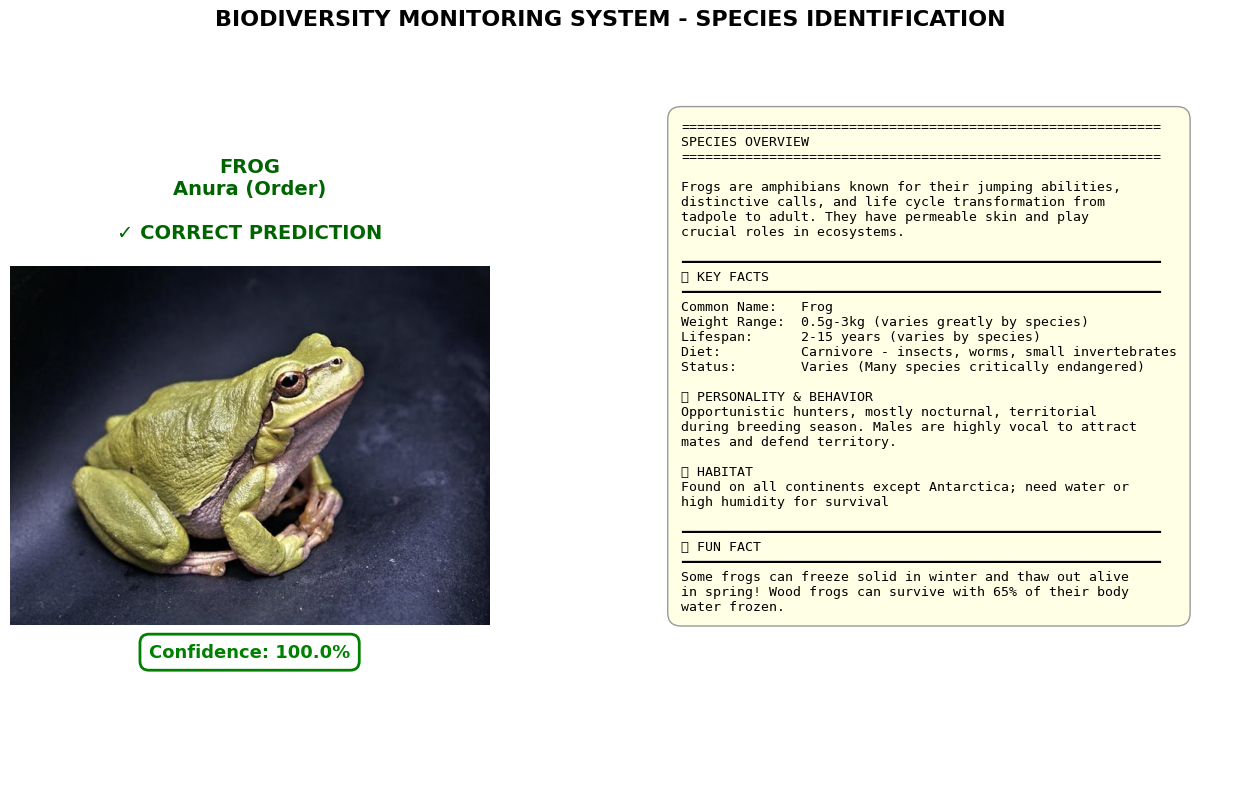


--- Details for PREDICTED species: Frog ---

┌────────────────────────────────────────────────────────────────────┐
│ DETAILED INFORMATION: FROG                                           │
└────────────────────────────────────────────────────────────────────┘

📋 Classification: Anura (Order)

❤️ LIKES:
  • Moist environments, insects (flies, mosquitoes, beetles),
  • standing water for breeding, moderate temperatures, and hiding in
  • vegetation

💔 DISLIKES:
  • Dry conditions, salt water, pollution, pesticides, extreme
  • temperatures, and bright lights

🛡️ CONSERVATION:
  Status: Varies (Many species critically endangered)
  Trend: Declining rapidly - amphibian crisis
  Threats: Habitat loss, climate change, pollution, chytrid fungus disease


Sample 243:
  Predicted: Dog
  Actual: Dog
  Status: ✓ CORRECT
  Confidence: 100.0%


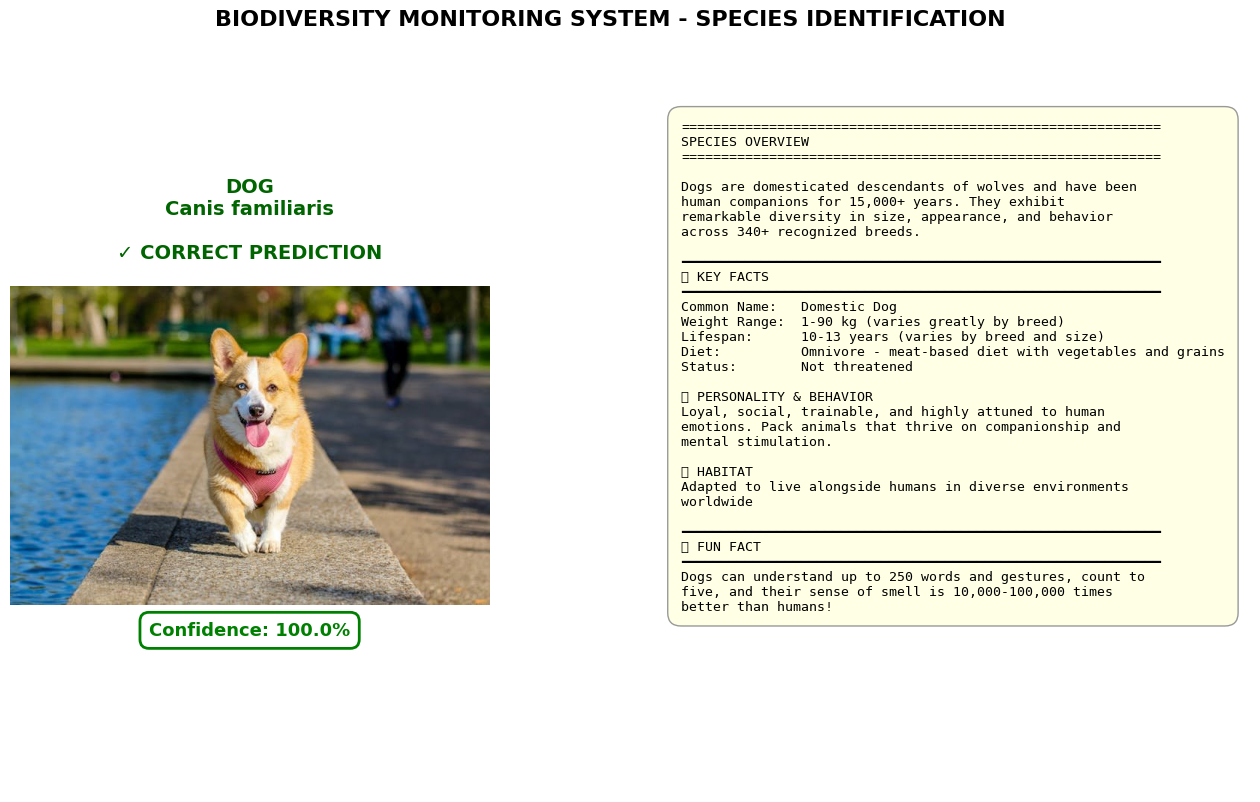


--- Details for PREDICTED species: Dog ---

┌────────────────────────────────────────────────────────────────────┐
│ DETAILED INFORMATION: DOG                                            │
└────────────────────────────────────────────────────────────────────┘

📋 Classification: Canis familiaris

❤️ LIKES:
  • Walks, running, play time, treats, belly rubs, social interaction
  • with humans and other dogs, mental challenges, and being with
  • their family

💔 DISLIKES:
  • Being alone for long periods, harsh discipline, baths (many
  • dogs), thunderstorms, fireworks, and vacuum cleaners

🛡️ CONSERVATION:
  Status: Not threatened
  Trend: Stable - estimated 900+ million dogs globally


Sample 145:
  Predicted: Chicken
  Actual: Chicken
  Status: ✓ CORRECT
  Confidence: 100.0%


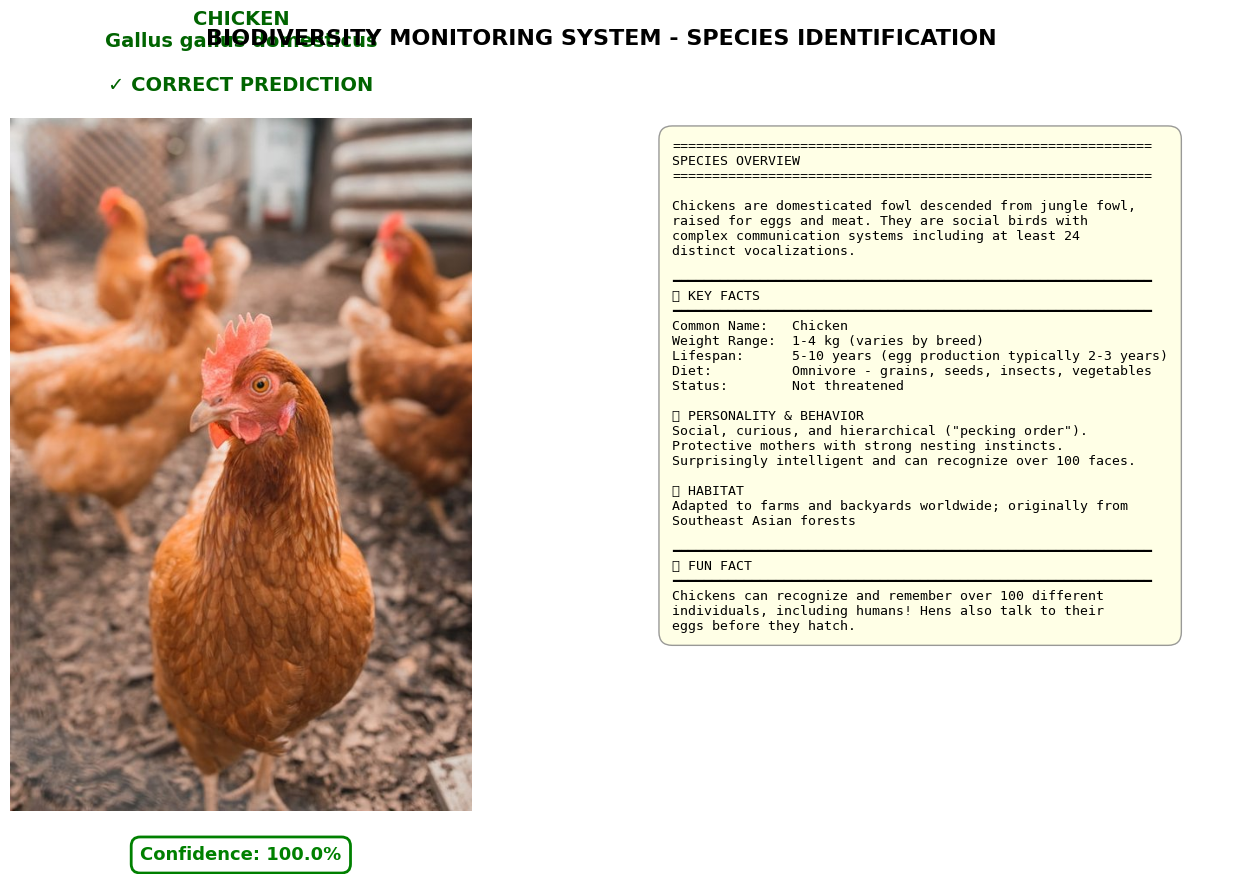


--- Details for PREDICTED species: Chicken ---

┌────────────────────────────────────────────────────────────────────┐
│ DETAILED INFORMATION: CHICKEN                                        │
└────────────────────────────────────────────────────────────────────┘

📋 Classification: Gallus gallus domesticus

❤️ LIKES:
  • Dust bathing, scratching for food, foraging for insects and
  • seeds, roosting at night, laying eggs in private nests, and
  • sunshine

💔 DISLIKES:
  • Predators (foxes, hawks, snakes), being handled roughly, dirty
  • coops, being isolated from the flock, and rain

🛡️ CONSERVATION:
  Status: Not threatened
  Trend: Stable - over 25 billion chickens worldwide


Sample 172:
  Predicted: Dog
  Actual: Dog
  Status: ✓ CORRECT
  Confidence: 99.9%


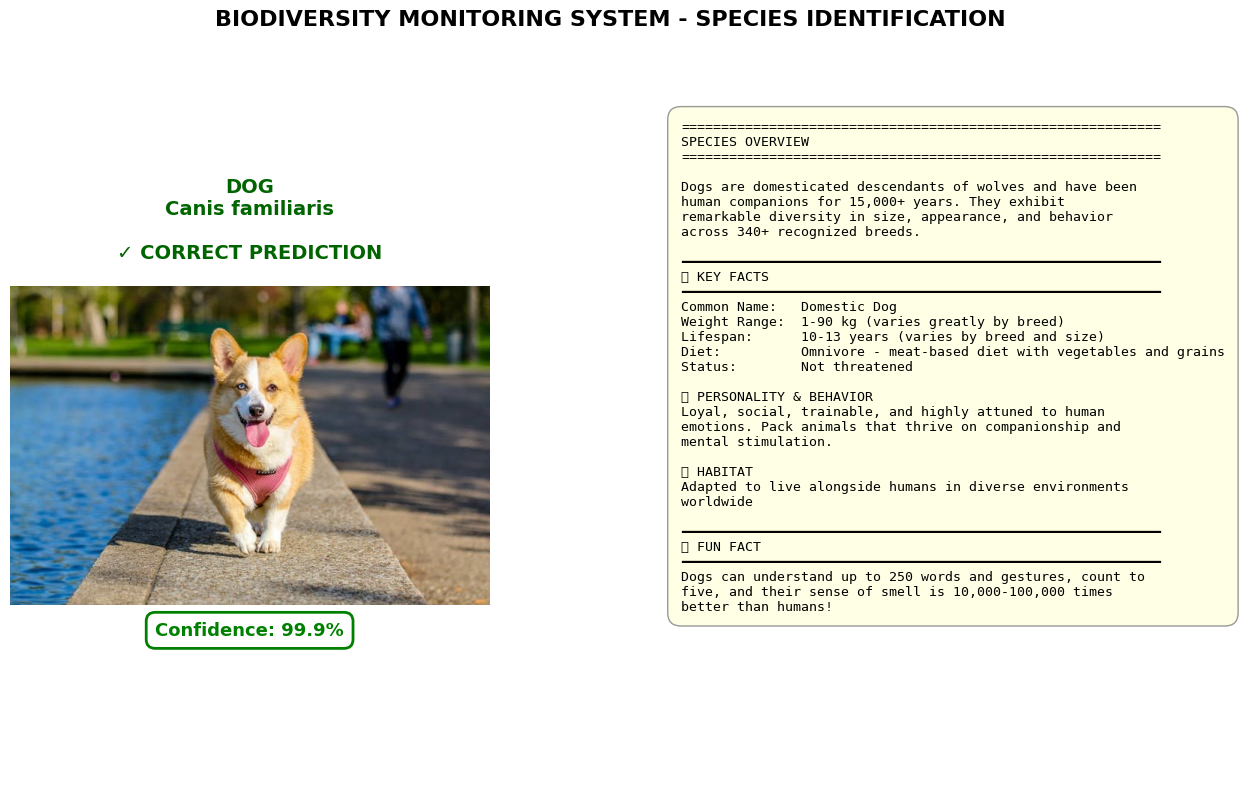


--- Details for PREDICTED species: Dog ---

┌────────────────────────────────────────────────────────────────────┐
│ DETAILED INFORMATION: DOG                                            │
└────────────────────────────────────────────────────────────────────┘

📋 Classification: Canis familiaris

❤️ LIKES:
  • Walks, running, play time, treats, belly rubs, social interaction
  • with humans and other dogs, mental challenges, and being with
  • their family

💔 DISLIKES:
  • Being alone for long periods, harsh discipline, baths (many
  • dogs), thunderstorms, fireworks, and vacuum cleaners

🛡️ CONSERVATION:
  Status: Not threatened
  Trend: Stable - estimated 900+ million dogs globally


Sample 62:
  Predicted: Frog
  Actual: Frog
  Status: ✓ CORRECT
  Confidence: 99.9%


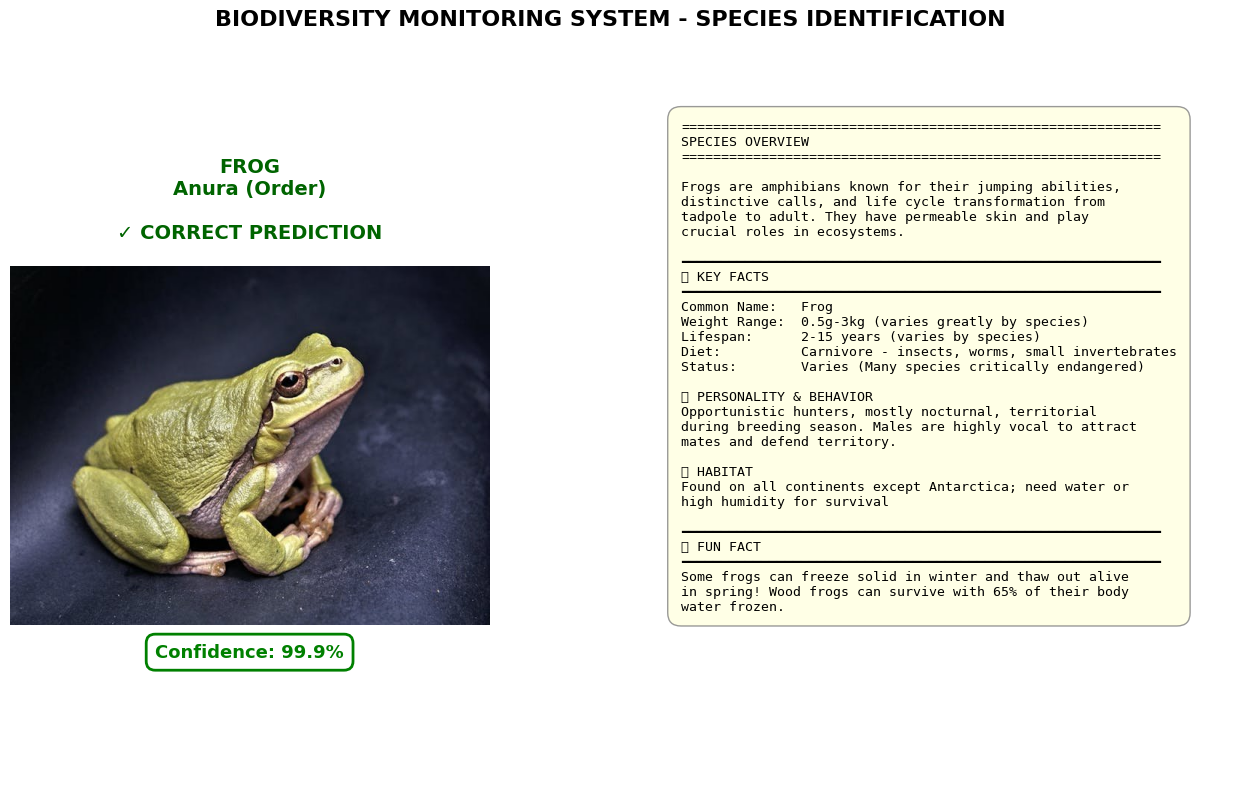


--- Details for PREDICTED species: Frog ---

┌────────────────────────────────────────────────────────────────────┐
│ DETAILED INFORMATION: FROG                                           │
└────────────────────────────────────────────────────────────────────┘

📋 Classification: Anura (Order)

❤️ LIKES:
  • Moist environments, insects (flies, mosquitoes, beetles),
  • standing water for breeding, moderate temperatures, and hiding in
  • vegetation

💔 DISLIKES:
  • Dry conditions, salt water, pollution, pesticides, extreme
  • temperatures, and bright lights

🛡️ CONSERVATION:
  Status: Varies (Many species critically endangered)
  Trend: Declining rapidly - amphibian crisis
  Threats: Habitat loss, climate change, pollution, chytrid fungus disease


Sample 203:
  Predicted: Cow
  Actual: Cow
  Status: ✓ CORRECT
  Confidence: 100.0%


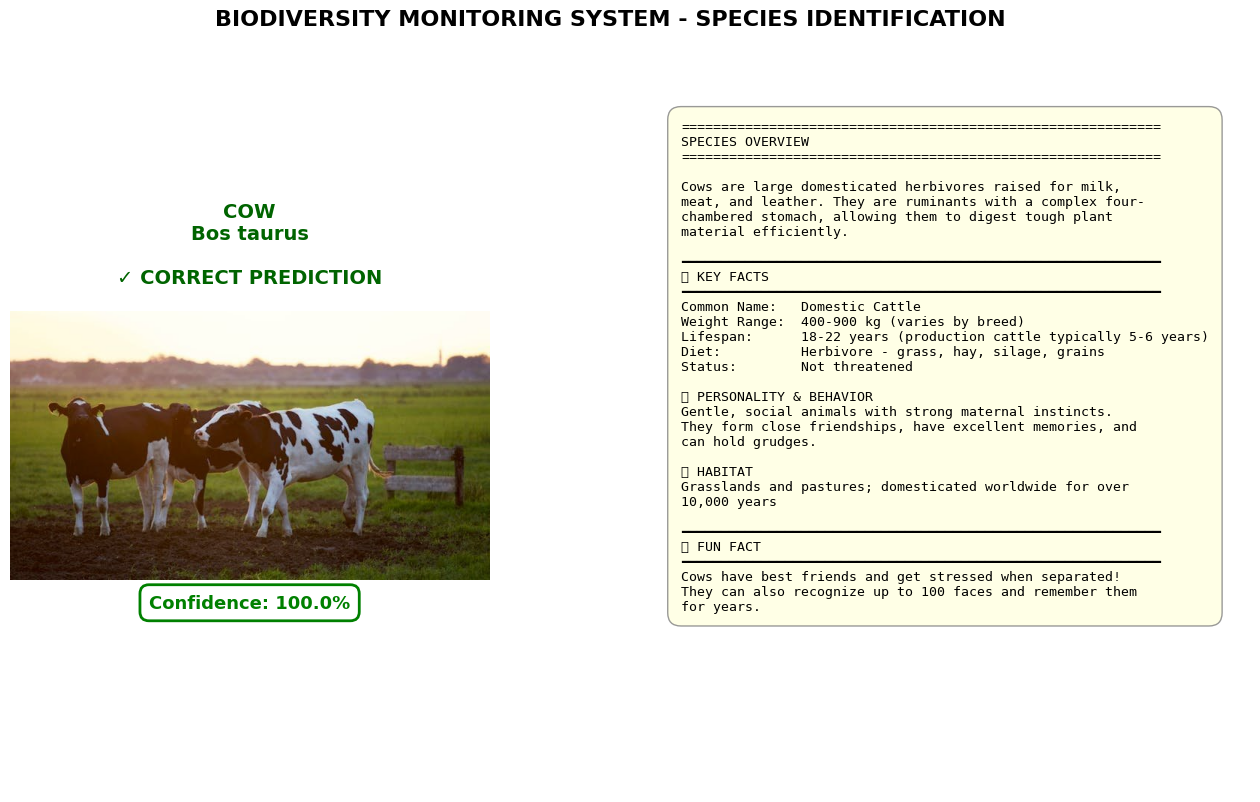


--- Details for PREDICTED species: Cow ---

┌────────────────────────────────────────────────────────────────────┐
│ DETAILED INFORMATION: COW                                            │
└────────────────────────────────────────────────────────────────────┘

📋 Classification: Bos taurus

❤️ LIKES:
  • Fresh grass, hay, alfalfa, mineral licks, socializing with herd
  • members, having their heads scratched, and shade on hot days

💔 DISLIKES:
  • Being alone, sudden movements, loud noises, dogs chasing them,
  • being separated from calves, and unfamiliar environments

🛡️ CONSERVATION:
  Status: Not threatened
  Trend: Stable - approximately 1 billion cattle globally


Sample 192:
  Predicted: Lion
  Actual: Lion
  Status: ✓ CORRECT
  Confidence: 100.0%


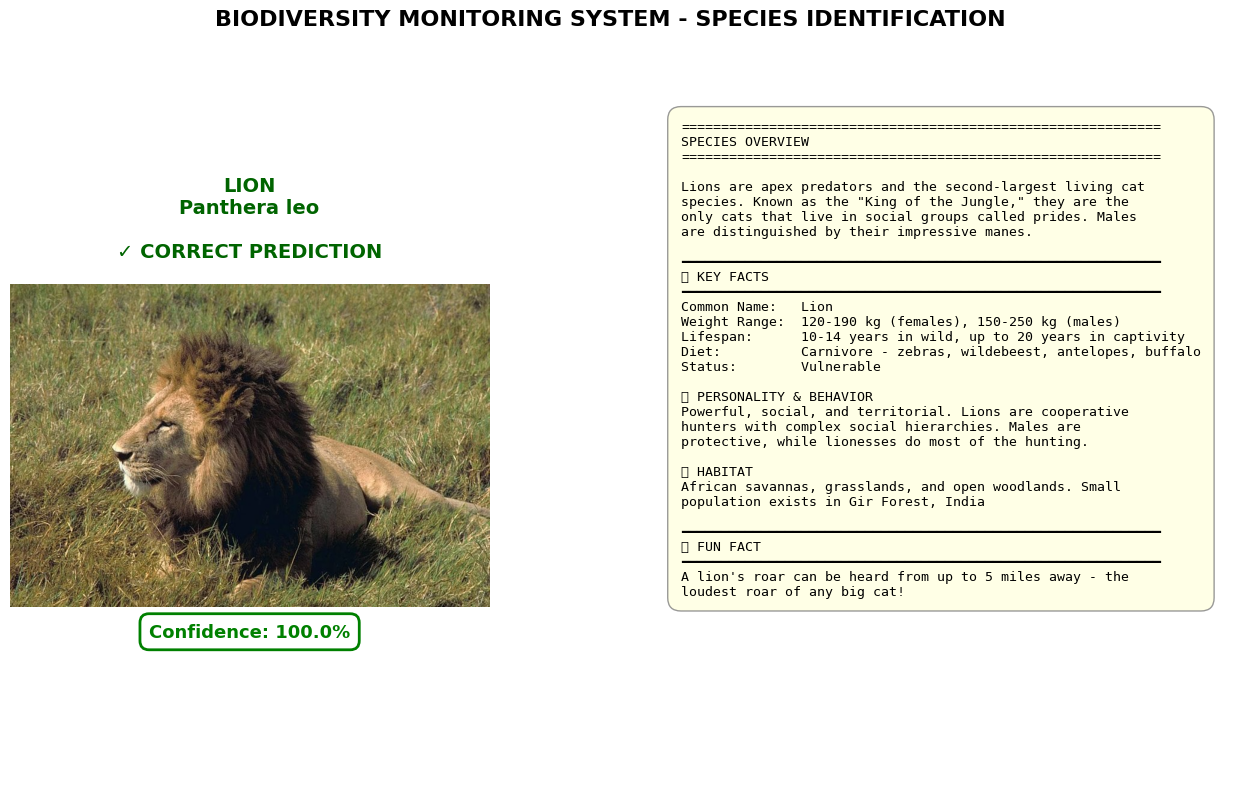


--- Details for PREDICTED species: Lion ---

┌────────────────────────────────────────────────────────────────────┐
│ DETAILED INFORMATION: LION                                           │
└────────────────────────────────────────────────────────────────────┘

📋 Classification: Panthera leo

❤️ LIKES:
  • Resting in shade (sleep 16-20 hours/day), hunting in groups,
  • fresh meat, socializing with pride members, and roaring to mark
  • territory

💔 DISLIKES:
  • Water (though they can swim if necessary), hyenas competing for
  • food, being challenged for dominance, and excessive heat

🛡️ CONSERVATION:
  Status: Vulnerable
  Trend: Declining - population declined by 43% over past 21 years
  Threats: Habitat loss, human-wildlife conflict, poaching


Sample 164:
  Predicted: Cat
  Actual: Cat
  Status: ✓ CORRECT
  Confidence: 100.0%


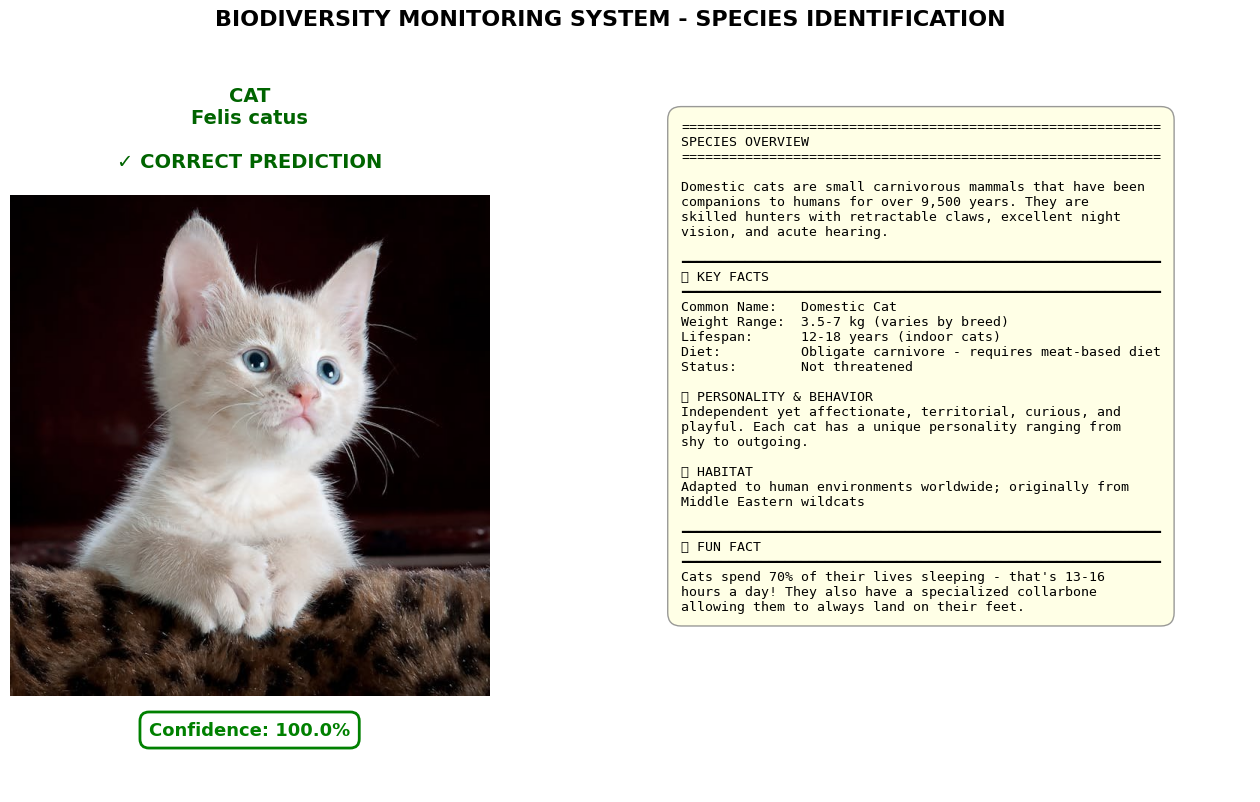


--- Details for PREDICTED species: Cat ---

┌────────────────────────────────────────────────────────────────────┐
│ DETAILED INFORMATION: CAT                                            │
└────────────────────────────────────────────────────────────────────┘

📋 Classification: Felis catus

❤️ LIKES:
  • Warm sunny spots, high places for observation, interactive play,
  • grooming, catnip, and quality sleep (12-16 hours daily)

💔 DISLIKES:
  • Water (most cats), citrus scents, loud noises, being restrained,
  • dirty litter boxes, and unfamiliar people

🛡️ CONSERVATION:
  Status: Not threatened
  Trend: Stable - estimated 600+ million domestic cats worldwide


Sample 27:
  Predicted: Chicken
  Actual: Chicken
  Status: ✓ CORRECT
  Confidence: 100.0%


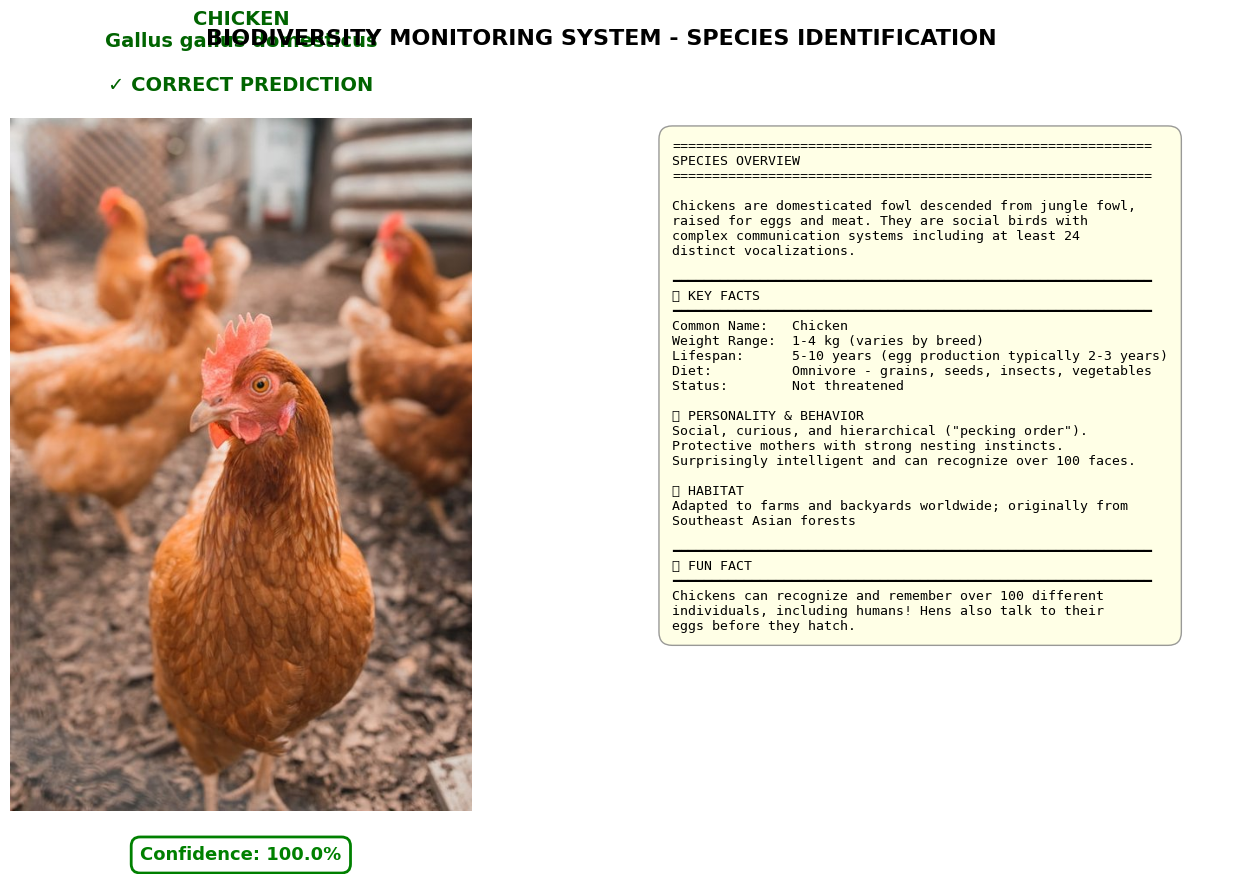


--- Details for PREDICTED species: Chicken ---

┌────────────────────────────────────────────────────────────────────┐
│ DETAILED INFORMATION: CHICKEN                                        │
└────────────────────────────────────────────────────────────────────┘

📋 Classification: Gallus gallus domesticus

❤️ LIKES:
  • Dust bathing, scratching for food, foraging for insects and
  • seeds, roosting at night, laying eggs in private nests, and
  • sunshine

💔 DISLIKES:
  • Predators (foxes, hawks, snakes), being handled roughly, dirty
  • coops, being isolated from the flock, and rain

🛡️ CONSERVATION:
  Status: Not threatened
  Trend: Stable - over 25 billion chickens worldwide


PREDICTION PERFORMANCE SUMMARY

Overall Statistics:
  Total test samples:      259
  Correct predictions:     257 (99.2%)
  Incorrect predictions:   2 (0.8%)
  Samples displayed:       9

Species         Icon  Correct  Total    Accuracy  
───────────────────────────────────────────────────────
Bird            

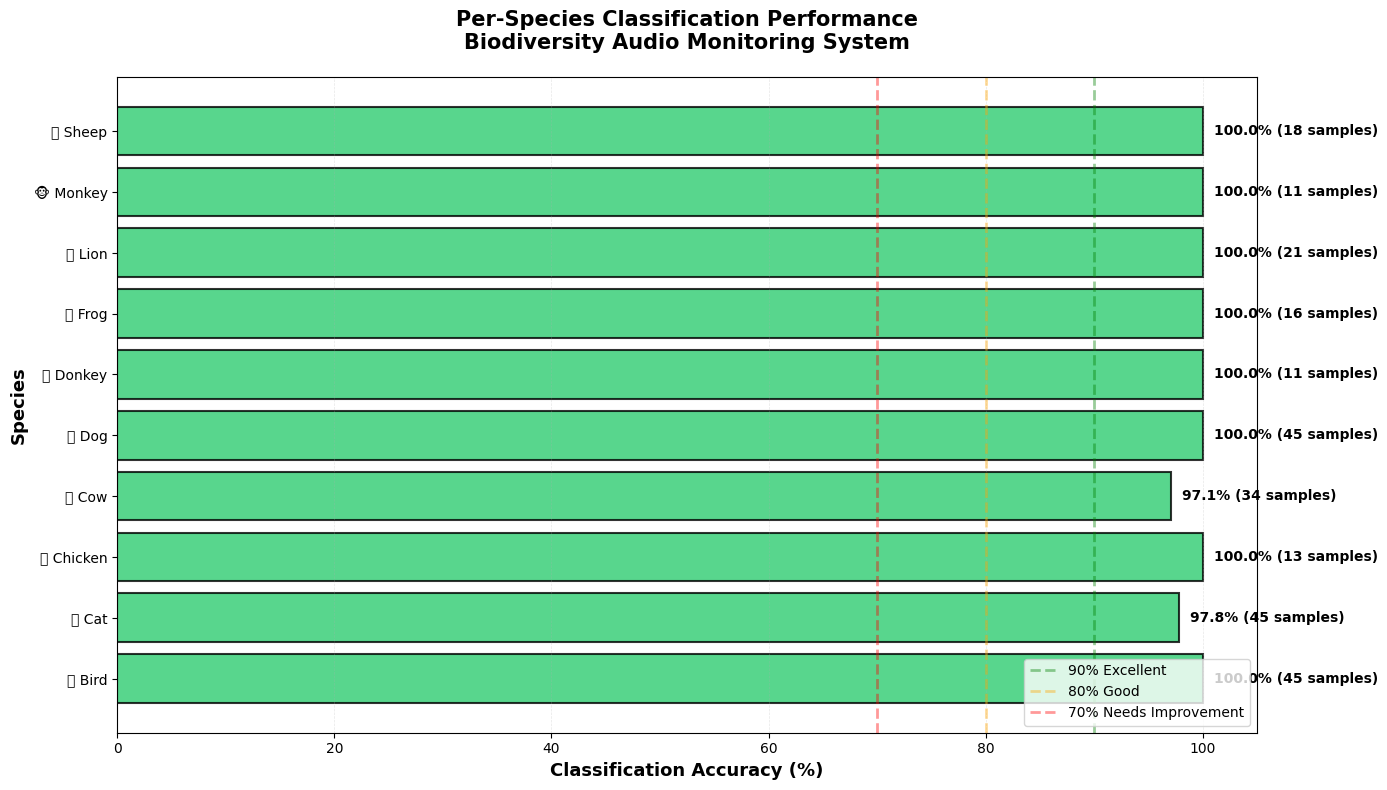


SPECIES VISUALIZATION COMPLETE


In [27]:
print("\n" + "=" * 70)
print("SECTION 13: SPECIES IDENTIFICATION WITH REAL IMAGES")
print("=" * 70)

import json
from PIL import Image
import textwrap

# Load species database
SPECIES_DIR = 'species_data'
IMAGES_DIR = os.path.join(SPECIES_DIR, 'images')

print("\nLoading species database and images...")

# Load species information
db_path = os.path.join(SPECIES_DIR, 'species_database.json')
if os.path.exists(db_path):
    with open(db_path, 'r') as f:
        SPECIES_DATABASE = json.load(f)
    print(f"✓ Loaded information for {len(SPECIES_DATABASE)} species")
else:
    print("✗ Species database not found. Please run Section 12.5 first.")
    SPECIES_DATABASE = {}

def display_species_card_with_image(species_name, is_correct, confidence, true_species=None):
    """Display species with real image and information"""

    if species_name not in SPECIES_DATABASE:
        print(f"Warning: {species_name} not in database")
        return None

    info = SPECIES_DATABASE[species_name]
    image_path = os.path.join(IMAGES_DIR, f'{species_name.lower()}.jpg')

    # Create figure with image and info side by side
    fig = plt.figure(figsize=(16, 9))
    gs = fig.add_gridspec(1, 2, width_ratios=[1.2, 1.5], wspace=0.3)

    # LEFT PANEL: Image
    ax_img = fig.add_subplot(gs[0])
    if os.path.exists(image_path):
        img = Image.open(image_path)
        ax_img.imshow(img)
    else:
        ax_img.text(0.5, 0.5, f'Image Not Available\n{species_name}',
                    ha='center', va='center', fontsize=16,
                    bbox=dict(boxstyle='round', facecolor='lightgray'))

    ax_img.axis('off')

    # Title with status
    status_color = 'darkgreen' if is_correct else 'darkred'
    status_symbol = '✓' if is_correct else '✗'
    status_text = f'{status_symbol} CORRECT PREDICTION' if is_correct else f'{status_symbol} INCORRECT PREDICTION'

    title = f'{species_name.upper()}\n{info["scientific_name"]}\n\n{status_text}'
    if not is_correct and true_species:
        title += f'\n(Actual: {true_species})'

    ax_img.set_title(title, fontsize=14, fontweight='bold',
                     color=status_color, pad=20)

    # Confidence badge
    conf_color = 'green' if confidence >= 90 else 'orange' if confidence >= 75 else 'red'
    ax_img.text(0.5, -0.05, f'Confidence: {confidence:.1f}%',
                transform=ax_img.transAxes, ha='center', va='top',
                fontsize=13, fontweight='bold', color=conf_color,
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white',
                          edgecolor=conf_color, linewidth=2))

    # RIGHT PANEL: Information
    ax_info = fig.add_subplot(gs[1])
    ax_info.axis('off')

    # Format information text
    info_lines = []

    info_lines.append("=" * 60)
    info_lines.append("SPECIES OVERVIEW")
    info_lines.append("=" * 60)
    info_lines.append("")
    wrapped_summary = textwrap.fill(info['summary'], width=58)
    info_lines.append(wrapped_summary)
    info_lines.append("")

    info_lines.append("━" * 60)
    info_lines.append("📊 KEY FACTS")
    info_lines.append("━" * 60)
    info_lines.append(f"Common Name:   {info['common_name']}")
    info_lines.append(f"Weight Range:  {info['weight_range']}")
    info_lines.append(f"Lifespan:      {info['lifespan']}")
    info_lines.append(f"Diet:          {info['diet']}")
    info_lines.append(f"Status:        {info['conservation_status']}")
    info_lines.append("")

    info_lines.append("🎭 PERSONALITY & BEHAVIOR")
    wrapped_personality = textwrap.fill(info['personality'], width=58)
    info_lines.append(wrapped_personality)
    info_lines.append("")

    info_lines.append("🌍 HABITAT")
    wrapped_habitat = textwrap.fill(info['habitat'], width=58)
    info_lines.append(wrapped_habitat)
    info_lines.append("")

    info_lines.append("━" * 60)
    info_lines.append("✨ FUN FACT")
    info_lines.append("━" * 60)
    wrapped_fact = textwrap.fill(info['fun_fact'], width=58)
    info_lines.append(wrapped_fact)

    text_content = '\n'.join(info_lines)
    ax_info.text(0.05, 0.97, text_content, transform=ax_info.transAxes,
                 fontsize=9.5, verticalalignment='top', family='monospace',
                 bbox=dict(boxstyle='round,pad=1', facecolor='lightyellow',
                           alpha=0.8, edgecolor='gray', linewidth=1))

    plt.suptitle('BIODIVERSITY MONITORING SYSTEM - SPECIES IDENTIFICATION',
                 fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout()
    return fig

def display_species_details(species_name):
    """Display detailed text information for a species"""
    if species_name not in SPECIES_DATABASE:
        print(f"Warning: {species_name} not in database")
        return

    info = SPECIES_DATABASE[species_name]

    print("\n" + "┌" + "─" * 68 + "┐")
    print(f"│ DETAILED INFORMATION: {species_name.upper():<46} │")
    print("└" + "─" * 68 + "┘")

    print(f"\n📋 Classification: {info['scientific_name']}")

    print(f"\n❤️ LIKES:")
    for line in textwrap.wrap(info['likes'], width=65):
        print(f"  • {line}")

    print(f"\n💔 DISLIKES:")
    for line in textwrap.wrap(info['dislikes'], width=65):
        print(f"  • {line}")

    print(f"\n🛡️ CONSERVATION:")
    print(f"  Status: {info['conservation_status']}")
    print(f"  Trend: {info['population_trend']}")
    if info.get('threats') != 'None (domesticated species)':
        print(f"  Threats: {info['threats']}")

    print()

# --- Load results from Cell 12 ---
print("\nLoading prediction results from Cell 12...")

selected_samples = []

try:
    if isinstance(sim_correct_indices, list) and isinstance(sim_incorrect_indices, list):
        selected_correct = sim_correct_indices
        selected_incorrect = sim_incorrect_indices
        selected_samples = selected_correct + selected_incorrect
        print(f"✓ Loaded {len(selected_correct)} correct and {len(selected_incorrect)} incorrect samples from Cell 12 simulation.")
    else:
        raise NameError("Cell 12 variables not found or are wrong type.")
except NameError:
    print("✗ WARNING: Cell 12 simulation results not found (was Cell 12 run?).")
    print("Displaying 2 random correct and 1 random incorrect sample as fallback.")
    all_correct = [i for i, (pred, true) in enumerate(zip(y_pred_classes, y_true_classes)) if pred == true]
    all_incorrect = [i for i, (pred, true) in enumerate(zip(y_pred_classes, y_true_classes)) if pred != true]

    selected_correct = np.random.choice(all_correct, 2, replace=False).tolist() if len(all_correct) >= 2 else all_correct
    selected_incorrect = np.random.choice(all_incorrect, 1, replace=False).tolist() if len(all_incorrect) >= 1 else []
    selected_samples = selected_correct + selected_incorrect

# --- Ensure a Chicken is shown ---
try:
    chicken_label_idx = label_encoder.transform(['Chicken'])[0]
    found_chicken_idx = -1
    for i in range(len(X_test)):
        if y_true_classes[i] == chicken_label_idx and y_pred_classes[i] == chicken_label_idx:
            found_chicken_idx = i
            break

    if found_chicken_idx != -1 and found_chicken_idx not in selected_samples:
        print("✓ Adding a correctly predicted 'Chicken' 🐔 sample as requested.")
        selected_samples.append(found_chicken_idx)
    elif found_chicken_idx in selected_samples:
        print("✓ A 'Chicken' 🐔 sample from Cell 12 is already in the display list.")
    else:
        print("✗ Could not find a correctly predicted 'Chicken' 🐔 sample in the test set to add.")
except Exception as e:
    print(f"Could not add 'Chicken' 🐔 sample: {e}")

print(f"Total samples to display: {len(selected_samples)}\n")

# Display each selected prediction
print("=" * 70)
print("DISPLAYING SPECIES PREDICTIONS WITH REAL IMAGES")
print("=" * 70)
print()

displayed_count = 0

if not selected_samples:
    print("No samples were selected to display. Please check Cell 12 and the test set.")

for sample_idx in selected_samples:
    true_species = label_encoder.classes_[y_true_classes[sample_idx]]
    pred_species = label_encoder.classes_[y_pred_classes[sample_idx]]
    confidence = y_pred[sample_idx][y_pred_classes[sample_idx]] * 100
    is_correct = true_species == pred_species

    if pred_species not in SPECIES_DATABASE:
        print(f"Skipping sample {sample_idx}: Predicted species '{pred_species}' not in database.")
        continue

    print(f"\n{'='*70}")
    print(f"Sample {sample_idx}:")
    print(f"  Predicted: {pred_species}")
    print(f"  Actual: {true_species}")
    print(f"  Status: {'✓ CORRECT' if is_correct else '✗ INCORRECT'}")
    print(f"  Confidence: {confidence:.1f}%")

    # Display card with image
    fig = display_species_card_with_image(pred_species, is_correct, confidence, true_species)
    if fig:
        plt.show()
        plt.close()

    displayed_count += 1

    # FIXED: Always show detailed information for each sample
    # Show predicted species details
    print(f"\n--- Details for PREDICTED species: {pred_species} ---")
    display_species_details(pred_species)

    # For incorrect predictions, also show actual species details
    if not is_correct and true_species in SPECIES_DATABASE:
        print(f"\n--- Details for ACTUAL species: {true_species} ---")
        display_species_details(true_species)

print("\n" + "=" * 70)
print("PREDICTION PERFORMANCE SUMMARY")
print("=" * 70)

print(f"\nOverall Statistics:")
print(f"  Total test samples:      {len(X_test)}")
print(f"  Correct predictions:     {len(y_true_classes[y_true_classes == y_pred_classes])} ({len(y_true_classes[y_true_classes == y_pred_classes])/len(X_test)*100:.1f}%)")
print(f"  Incorrect predictions:   {len(y_true_classes[y_true_classes != y_pred_classes])} ({len(y_true_classes[y_true_classes != y_pred_classes])/len(X_test)*100:.1f}%)")
print(f"  Samples displayed:       {displayed_count}")

# Per-species accuracy table
print(f"\n{'Species':<15} {'Icon':<5} {'Correct':<8} {'Total':<8} {'Accuracy':<10}")
print("─" * 55)

species_stats = []

for species in sorted(label_encoder.classes_):
    if species in SPECIES_DATABASE:
        species_idx = label_encoder.transform([species])[0]
        species_mask = y_true_classes == species_idx

        if species_mask.sum() > 0:
            species_correct = (y_pred_classes[species_mask] == species_idx).sum()
            species_total = species_mask.sum()
            species_accuracy = species_correct / species_total * 100

            icons = {'Lion':'🦁', 'Cat':'🐈', 'Bird':'🐦', 'Dog':'🐕', 'Cow':'🐄',
                     'Monkey':'🐵', 'Chicken':'🐔', 'Donkey':'🫏', 'Frog':'🐸', 'Sheep':'🐑'}
            icon = icons.get(species, '❓')

            print(f"{species:<15} {icon:<5} {species_correct:<8} {species_total:<8} {species_accuracy:>6.1f}%")

            species_stats.append({
                'species': species,
                'icon': icon,
                'accuracy': species_accuracy,
                'total': species_total
            })

# Create visual accuracy chart
print("\n" + "=" * 70)
print("GENERATING ACCURACY VISUALIZATION")
print("=" * 70)

if species_stats:
    fig, ax = plt.subplots(figsize=(14, 8))

    species_names = [f"{s['icon']} {s['species']}" for s in species_stats]
    accuracies = [s['accuracy'] for s in species_stats]
    totals = [s['total'] for s in species_stats]

    colors = ['#2ecc71' if acc >= 90 else '#f39c12' if acc >= 75 else '#e74c3c'
              for acc in accuracies]

    bars = ax.barh(species_names, accuracies, color=colors, edgecolor='black',
                   linewidth=1.5, alpha=0.8)

    for i, (bar, acc, total) in enumerate(zip(bars, accuracies, totals)):
        width = bar.get_width()
        ax.text(width + 1, bar.get_y() + bar.get_height()/2,
                f'{acc:.1f}% ({total} samples)', ha='left', va='center',
                fontweight='bold', fontsize=10)

    ax.axvline(x=90, color='green', linestyle='--', alpha=0.4, linewidth=2, label='90% Excellent')
    ax.axvline(x=80, color='orange', linestyle='--', alpha=0.4, linewidth=2, label='80% Good')
    ax.axvline(x=70, color='red', linestyle='--', alpha=0.4, linewidth=2, label='70% Needs Improvement')

    ax.set_xlabel('Classification Accuracy (%)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Species', fontsize=13, fontweight='bold')
    ax.set_title('Per-Species Classification Performance\nBiodiversity Audio Monitoring System',
                 fontsize=15, fontweight='bold', pad=20)
    ax.set_xlim(0, 105)
    ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
    ax.legend(loc='lower right', fontsize=10)

    plt.tight_layout()
    plt.show()

print("\n" + "=" * 70)
print("SPECIES VISUALIZATION COMPLETE")
print("=" * 70)

**14: SAVE MODELS AND METADATA**

In [28]:
print("\n" + "=" * 70)
print("SECTION 13: SAVING MODELS AND METADATA")
print("=" * 70)

# Save Keras model
model.save('animal_classifier_full.keras')
print("\nSaved full Keras model: animal_classifier_full.keras")

# Save label encoder classes
np.save('label_classes.npy', label_encoder.classes_)
print("Saved label classes: label_classes.npy")

# Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)
print("Saved training history: training_history.csv")

# Create metadata file
metadata = {
    'model_name': 'Animal Species Audio Classifier',
    'num_classes': len(SPECIES),
    'species': list(SPECIES),
    'sample_rate': SAMPLE_RATE,
    'duration': DURATION,
    'input_shape': list(X_train.shape[1:]),
    'test_accuracy': float(test_accuracy),
    'tflite_accuracy': float(tflite_accuracy),
    'model_size_mb': float(original_size),
    'tflite_size_mb': float(tflite_size),
    'inference_time_ms': float(inference_time),
    'total_parameters': int(param_count)
}

import json
with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)
print("Saved metadata: model_metadata.json")


SECTION 13: SAVING MODELS AND METADATA

Saved full Keras model: animal_classifier_full.keras
Saved label classes: label_classes.npy
Saved training history: training_history.csv
Saved metadata: model_metadata.json


**15: PROJECT SUMMARY**

In [29]:
print("\n" + "=" * 70)
print("SECTION 14: PROJECT SUMMARY & DEPLOYMENT RECOMMENDATIONS")
print("=" * 70)

print(f"""
PROJECT ACHIEVEMENTS:
   - Successfully trained lightweight CNN for animal species classification
   - Dataset: {len(audio_data)} samples across {len(SPECIES)} species
   - Test Accuracy: {test_accuracy*100:.1f}%
   - Model Size: Reduced from {original_size:.2f} MB to {tflite_size:.2f} MB ({(1-tflite_size/original_size)*100:.1f}% reduction)
   - Inference Time: {inference_time:.2f} ms (suitable for real-time processing)

DEPLOYMENT SPECIFICATIONS:
   - Target Hardware: ESP32, Raspberry Pi, Arduino Nano 33 BLE, or similar
   - Power Consumption: Can run on battery with duty-cycled operation
   - Model Format: TensorFlow Lite (quantized INT8)
   - Input: {DURATION}-second audio clips at {SAMPLE_RATE} Hz
   - Output: Species classification with confidence scores

RECOMMENDED OPERATIONAL WORKFLOW:
   1. Microphone captures ambient sound continuously
   2. Audio segmented into {DURATION}-second windows with 1-second overlap
   3. On-device preprocessing: Convert to Mel-spectrogram
   4. Model inference: Classify species
   5. Log detections with timestamp and confidence
   6. Enter sleep mode between detections (power saving)

SCALABILITY IMPROVEMENTS:
   - Expand to 50+ species using transfer learning
   - Implement active learning to improve on misclassifications
   - Add background noise robustness through data augmentation
   - Deploy federated learning for multi-device biodiversity networks

BIODIVERSITY MONITORING IMPACT:
   - Enables 24/7 autonomous monitoring in remote locations
   - Low cost and low power enables large-scale deployment
   - Real-time species detection for conservation efforts
   - Data collection for population trend analysis""")

print("\n" + "=" * 70)
print("PROJECT COMPLETE - READY FOR PRESENTATION")
print("=" * 70)
print("\nNext steps: Deploy to hardware and test in field conditions!")
print("\nTo download files from Colab:")
print("  from google.colab import files")
print("  files.download('animal_classifier_quantized.tflite')")
print("  files.download('model_metadata.json')")
print("=" * 70)


SECTION 14: PROJECT SUMMARY & DEPLOYMENT RECOMMENDATIONS

PROJECT ACHIEVEMENTS:
   - Successfully trained lightweight CNN for animal species classification
   - Dataset: 574 samples across 10 species
   - Test Accuracy: 99.2%
   - Model Size: Reduced from 0.79 MB to 0.22 MB (72.6% reduction)
   - Inference Time: 14.90 ms (suitable for real-time processing)

DEPLOYMENT SPECIFICATIONS:
   - Target Hardware: ESP32, Raspberry Pi, Arduino Nano 33 BLE, or similar
   - Power Consumption: Can run on battery with duty-cycled operation
   - Model Format: TensorFlow Lite (quantized INT8)
   - Input: 3-second audio clips at 22050 Hz
   - Output: Species classification with confidence scores

RECOMMENDED OPERATIONAL WORKFLOW:
   1. Microphone captures ambient sound continuously
   2. Audio segmented into 3-second windows with 1-second overlap
   3. On-device preprocessing: Convert to Mel-spectrogram
   4. Model inference: Classify species
   5. Log detections with timestamp and confidence
   6. En